# 3'READS+ Pipeline (Part 2)
**This notebook is the Part 2 of the 3'READS+ pipeline, which will do the following:**

1. Register settings for this analysis. One experiment can be analysed with different settings (parameters). The results for each setting will be saved in different folders under the *result_dir* directory. 
2. Extend annotated 3'UTR regions to allow identification of new pA sites in previously poorly annotated 3'UTRs. 
3. Assign pA clusters identified in Part 1 to genomic features such as extended 3'UTRs, introns, CDSs, and 5'UTRs.
4. Resolve pA sites mapped to multiple genes.
5. Map intergenic and intronic pA sites to Non-Coding RNAs (ncRNAs).
6. Map remaining intergenic pA sites to Upstream Antisense RNAs (uaRNAs).
7. Plot the fractions of pA sites and PASS reads mapped to the mitochondria genome.
8. Resolve pA sites mapped to multiple genomic features of alternatively spliced gene.
9. Plot distribution of pA sites and PASS reads in different genomic features of each sample.
10. Plot nucleotide profile near pA sites mapped to different genomic regions.
11. Calculate optimal Transcript Starting Sites (TSSs).
12. Calculate CDS, intronic, 5'UTR, 3'UTR, and ncRNA features (such as size, GC content, and uORF) and check their relationships.
13. Identify subtypes of pA sites.
14. Identify poly(A) signal (PAS).
15. Check if different subtypes of pA sites tend to use different poly(A) signal (PAS).
16. Add gene symbols and Entrez gene ids.
17. Calculate gene expression-related features, such as pA site level RPM, gene level RPM, and pA site usage.
18. Filter out lowly expressed 3'UTR pAs.
19. Calculate number of pA sites per gene and its relationship with 3'UTR and CDS GC%.
20. Cluster samples using corrrelation between RPMs.


**Required softwares**

 * [dzlib.R](https://github.com/DinghaiZ/3-prime-READS-plus/blob/master/modules/dzlib.R) in the [modules](https://github.com/DinghaiZ/3-prime-READS-plus/tree/master/modules) folder 
 * Jupyter Lab or Jupyter Notebook for runing this notebook
 * R packages: foreach, doParallel, ShortRead, Biostrings, dplyr, tidyr, grid, ggplot2, plotly, etc
 * Linux environment
 
**Hardware requirements**
 * Muticore CPU for parallel computing

## 1. Set configurations specific to this analysis
These parameters need to be specified for different projects and experiments. One experiment can be analysed with different settings. 

In [1]:
MODULE_DIR = "/home/dinghai/dev/3-prime-READS-plus/modules"

# SHARED_DATA_DIR is a directory containing frequently used data, such as annotation databases.
SHARED_DATA_DIR = '/home/dinghai/projects/fud'

# Each data set can be analyzed with different parameter settings
SETTING = 'NT_AS_RC'

In [2]:
if(SETTING == 'NT_AS_RC'){
  # Which genome was used for mapping?  
  GENOME = 'mm9' # Genome name, currently either mm9 or hg19
  # Define which sample conditions to focus on
  # As mentioned in Part-1 of the pipeline, sample names should be in the format of 
  # "Treatment_Fraction_Batch", such as in "NT_C_1" and "NT_N_1".
  treatments = c("NT", "AS", "RC") # Order matters. Earlier ones will be reference
  fractions = c("4sU", "Ft") # Order matters. Earlier ones will be reference 
  comparisons = c("Ft_4sU") # Comparisons to make: N vs C
    
  # Use unique PASS reads for analysis?
  uPASS = F 
  if(uPASS){
    cluster_file = paste0('../results/clusters.using.unique.reads.csv')
    cluster_min_count = 2
  }else{
    cluster_file = paste0('../results/clusters.using.all.reads.csv')
    cluster_min_count = 5
  }
    
  # Settings for filtering low expression pAs 
  lowest_usage = 0 # Percentage 
  lowest_rpm = 0 # 
  lowest_count = 5
  filter_strength = 1 # Fraction of samples satisfying the filters
    
  # When a pA site map to mutlple genomic features of the same gene due to alternative splicing,
  # should we simplify the "region" annotation? 
  simplify_region_annotation = T
  
  # Settings for identifying aUTRs
  neighbor = F # Calculate aUTRs for each neighboring isoforms?
  toptwo = T # Pick top two isoforms for each gene?
  
  # Number of CPUs for parallel computing 
  MAX_WORKERS = 8  
}

In [3]:
result_dir = paste0("../results/", SETTING)
system(paste0("mkdir ", result_dir))
cat("Analysis results will be saved in the following directory:", result_dir) 

Analysis results will be saved in the following directory: ../results/NT_AS_RC

Load packages:

In [5]:
oldw = getOption("warn")
options(warn = -1)
require(tidyr)
require(magrittr)
require(dplyr)
require(ggplot2)
require(plotly)
require(gplots)
require(GenomicFeatures)
require(GenomicRanges)
require(Biostrings)
require(docstring)
require(foreach)
require(doParallel)
registerDoParallel(MAX_WORKERS)
theme_set(theme_bw(base_size = 15) + theme(plot.title = element_text(hjust = 0.5)))
library(repr)

# Depending on the genome, load the right packages:
if(GENOME == "mm9"){
  require("org.Mm.eg.db")
  org.db = org.Mm.eg.db
  txdb_path = file.path(SHARED_DATA_DIR, "mm9.refGene.txdb.sqlite")
  BSspec = "Mmusculus"
}else if(GENOME == "hg19"){
  require("org.Hs.eg.db")
  org.db = org.Hs.eg.db
  txdb_path = file.path(SHARED_DATA_DIR, "hg19.refGene.txdb.sqlite")
  BSspec = "Hsapiens"
}
    
BSgeno = paste0("BSgenome.", BSspec, ".UCSC.", GENOME)
require(BSgeno, character.only = T) 

options(warn = oldw)

If the txdb has not been downloaded yet, download it and save it to the shared data directory:

In [6]:
tryCatch(
  {txdb = loadDb(txdb_path)},
  error = function(e){
    txdb = makeTxDbFromUCSC(genome = GENOME, tablename = 'refGene')
    saveDb(txdb, file.path(SHARED_DATA_DIRD, paste0(GENOME, ".refGene.txdb.sqlite")))
  }
)

Load custom functions defined in *dzlib.R*:

In [8]:
oldw = getOption("warn")
options(warn = -1)

source("/home/dinghai/dev/3-prime-READS-plus/modules/dzlib.R")

options(warn = oldw)

## 2. Extend annotated 3'UTR regions to allow identification of new pA sites in poorly annotated 3'UTRs. 

First, define a helper function that will be reused several times later. 

In [9]:
rename_grl = function(grl, old_key = "ACCNUM", new_key = "SYMBOL"){
    #' A function to rename GRanges in a GRangeList.
    
    # Convert a GRangeList to a GRanges for faster calculation
    gr = unlist(grl)

    # Convert the accession numbers of the genes into gene symbols
    names(gr) = mapIds(org.db, keys = names(gr), keytype = old_key, column = new_key)
    
    # Rebuild GRanges by gene symbol 
    grl = split(gr, names(gr))   

    # Collapse features
    grl = reduce(grl)
    
    # Remove GRanges that are on two strands
    grl[sapply(grl, function(x) length(strand(x)@values) == 1)]
}

To extend 3'UTRs, I first get 4 kb regions downstream of annotated 3'UTRs. If the downstream regions overlap with downstream genes, I'll shrink the downstream regions to avoid overlaps. On the other hand, if the beginnings of the downstream regions are located within any genes (e.g. intronic 3'UTRs), I will undo the extension by setting the start and end of the extension to be identical. Downstream regions are processed separately for 3'UTRs on the plus and minus strands. Finally, the 3'UTRs and downstream regions are combined to get extended 3'UTRs. **Please note that the extended 3'UTRs are just candidate 3'UTR regions. The exact 3'UTR boundaries will be determined by pA sites that can be mapped to them.**

In [8]:
# Get 3'UTR annotation from Refseq
threeUTRs = suppressWarnings(threeUTRsByTranscript(txdb, use.names=T))

# Rename the 3'URs with gene symbols
threeUTRs = rename_grl(threeUTRs, old_key = "ACCNUM", new_key = "SYMBOL")

# Convert to GRanges for later use
utr3 = unlist(threeUTRs)

# Get 4 kb downstream regions. 3'UTR regions not included
# Out of boundary regions need to be trimmed
ds = trim(suppressWarnings(flank(utr3, 4000, start=F)))

# Get GRanges for genes
genes = genes(txdb, filter=NULL, single.strand.genes.only=T)
 
# Find extensions that overlap with genes on positive strands:
olp = findOverlaps(ds[strand(ds) == "+"], genes[strand(genes) == "+"])

# Which 3'UTRs have been extended too far?
extended_into_genes = start(ds[strand(ds) == "+"][queryHits(olp)]) < 
                      start(genes[strand(genes) == "+"][subjectHits(olp)])

# Reset the extended region so that the extended region no longer overlap with genes
end(ds[strand(ds) == "+"][queryHits(olp)][extended_into_genes]) =
    start(genes[strand(genes) == "+"][subjectHits(olp)][extended_into_genes]) - 1 

# If the bebinning of 3'UTR downstream region is located within any genes, don't extend either.
width(ds[strand(ds) == "+"][queryHits(olp)][!extended_into_genes]) = 1 

# Find extensions that overlap with genes on negative strands:
olp = findOverlaps(ds[strand(ds) == "-"], genes[strand(genes) == "-"])

# Which 3'UTRs have been extended too far?
extended_into_genes = end(ds[strand(ds) == "-"][queryHits(olp)]) > 
                      end(genes[strand(genes) == "-"][subjectHits(olp)])

# Reset the extended region so that the extended region no longer overlap with genes
start(ds[strand(ds) == "-"][queryHits(olp)][extended_into_genes]) = 
    end(genes[strand(genes) == "-"][subjectHits(olp)][extended_into_genes]) + 1 

# If the bebinning of 3'UTR downstream region is located within any genes, don't extend either.
end(ds[strand(ds) == "-"][queryHits(olp)][!extended_into_genes]) = 
    start(ds[strand(ds) == "-"][queryHits(olp)][!extended_into_genes]) 

# Combind previous 3'UTR definition with the downstream region to define extended 3'UTRs
utr3 = resize(utr3, width = width(utr3) + width(ds)-1, fix="start")

# Rebuild 3'UTRs named by gene symbol 
threeUTRs = split(utr3, names(utr3))

'select()' returned 1:1 mapping between keys and columns


The above code will generate some warning messages. The second warning message was produced by the flank() function, but the trim() function will take care of the issue. Take a look at how the size of extensions distribute:

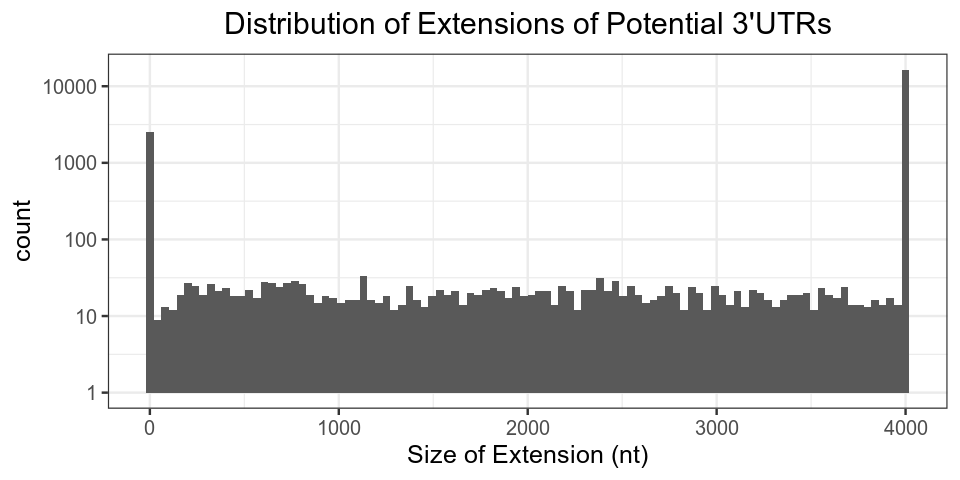

In [9]:
df = data.frame(extended = width(ds)) 

options(repr.plot.width=8, repr.plot.height=4)

ggplot(df, aes(extended)) +
  geom_histogram(bins=100) +
  scale_y_log10() +
  xlab("Size of Extension (nt)") +
  ggtitle("Distribution of Extensions of Potential 3'UTRs")

## 3.1. Read the pA cluster file created in Part-1 of the pipeline and create a GRange:
Only read data for the samples defined in Step 1. 

In [10]:
# Calculate sample names and batch numbers
header = strsplit(readLines(cluster_file, n = 1), ",")[[1]]

sample_names = grep(paste0("(", paste0(treatments, collapse="|"), 
                           ")_(", paste0(fractions,collapse="|"), 
                           ")_\\d+"), 
                    header[-c(1:3)], value = T)

batches = unique(sub(".+_(\\d+.?)$", "\\1", sample_names)) 

cat(paste0("The following samples will be used for the analysis named '", SETTING, "':")) 
sample_names

The following samples will be used for the analysis named 'NT_AS_RC':

[1] "AS_4sU_1" "AS_4sU_2" "AS_Ft_1"  "AS_Ft_2"  "NT_4sU_1" "NT_4sU_2"
 [7] "NT_4sU_3" "NT_Ft_1"  "NT_Ft_2"  "NT_Ft_3"  "RC_4sU_2" "RC_Ft_2"

In [11]:
# Only read desirable columns of the cluster file
cluster = read.csv(cluster_file)[, c("chromosome","strand","position", sample_names)]

# Require at least cluster_min_count reads for more than 2 samples
cluster = subset(cluster, rowSums(cluster[,-c(1:3)] >= cluster_min_count) >= 2)

# Create a GRanges object
pA = GRanges(seqnames = cluster$chromosome, strand = cluster$strand,
             ranges = IRanges(start = cluster$position, end = cluster$position))

mcols(pA, use.names = T) = cluster[,-c(1:3)]

rm(cluster)

## 3.2. Map the pA sites to extended 3'UTRs

In [12]:
pA$gene_symbol = ""
pA$region = ""
olp = findOverlaps(pA, threeUTRs)
pA[queryHits(olp), ]$gene_symbol = names(threeUTRs[subjectHits(olp)])
pA[queryHits(olp), ]$region = "3UTR"

## 3.3. Map the pA sites to introns
Code for steps 3.3 ~ 3.5 can be refactored later, since the steps are similar.

In [13]:
# Get intron annotation
introns = suppressWarnings(intronsByTranscript(txdb, use.names=T))

# Use the previously defined helper function to rename introns
introns = rename_grl(introns, old_key = "ACCNUM", new_key = "SYMBOL")

# Which clusters are mapped to which introns?
olp = findOverlaps(pA, introns)

# Some "intronic" pA sites have never been considered as 3'UTR pA sites 
index1 = which(pA[queryHits(olp), ]$gene_symbol == "")
pA[queryHits(olp), ][index1, ]$gene_symbol = names(introns[subjectHits(olp[index1,])])
pA[queryHits(olp), ][index1, ]$region = "intron"

# Some "intronic" pA sites have already been considered as 3'UTR pA sites 
index2 = which(pA[queryHits(olp), ]$gene_symbol != "")
pA[queryHits(olp), ][index2, ]$gene_symbol = paste0(pA[queryHits(olp), ][index2, ]$gene_symbol, 
                                                    "|", 
                                                    names(introns[subjectHits(olp[index2,])]))
pA[queryHits(olp), ][index2, ]$region = paste0(pA[queryHits(olp), ][index2, ]$region, "|intron")

'select()' returned 1:1 mapping between keys and columns


## 3.4. Map the pA sites to CDS
Code for steps 3.3 ~ 3.5 can be refactored later, since the steps are similar.

In [14]:
# Get CDS annotation
cds = suppressWarnings(cdsBy(txdb, by="tx", use.names=T))

# Use the previously defined helper function to rename CDS
cds = rename_grl(cds, old_key = "ACCNUM", new_key = "SYMBOL")

# Which clusters are mapped to which cds?
olp = findOverlaps(pA, cds)

# Some "CDS" pAs have never been considered as other featuers
index1 = which(pA[queryHits(olp), ]$gene_symbol == "")
if(length(index1) > 0){
  pA[queryHits(olp), ][index1, ]$gene_symbol = names(cds[subjectHits(olp[index1,])])
  pA[queryHits(olp), ][index1, ]$region = "CDS"
  }

# Some "CDS" have already been considered as other featuers
index2 = which(pA[queryHits(olp), ]$gene_symbol != "")
if(length(index2) > 0){
  pA[queryHits(olp), ][index2, ]$gene_symbol = 
    paste0(pA[queryHits(olp), ][index2, ]$gene_symbol, "|", 
           names(cds[subjectHits(olp[index2,])]))
  pA[queryHits(olp), ][index2, ]$region = paste0(pA[queryHits(olp), ][index2, ]$region, "|CDS")
  }

'select()' returned 1:1 mapping between keys and columns


## 3.5. Map the pA sites to 5'UTRs
Code for steps 3.3 ~ 3.5 can be refactored later, since the steps are similar.

In [15]:
# Get 5'UTR annotation
fiveUTRs = suppressWarnings(fiveUTRsByTranscript(txdb, use.names=T))

# Use the previously defined helper function to rename CDS
fiveUTRs = rename_grl(fiveUTRs, old_key = "ACCNUM", new_key = "SYMBOL")

# Which clusters are mapped to which 5'UTRs?
olp = findOverlaps(pA, fiveUTRs)

# Some 5'UTR pA sites have never been considered as other featuers
index1 = which(pA[queryHits(olp), ]$gene_symbol == "")
if(length(index1) > 0){
  pA[queryHits(olp), ][index1, ]$region = "5UTR"
  pA[queryHits(olp), ][index1, ]$gene_symbol = names(fiveUTRs[subjectHits(olp[index1,])])
  }

# Some 5'UTRs have already been considered as other featuers
index2 = which(pA[queryHits(olp), ]$gene_symbol != "")
if(length(index2) > 0){
  pA[queryHits(olp), ][index2, ]$region = paste0(pA[queryHits(olp), ][index2, ]$region, "|5UTR")
  pA[queryHits(olp), ][index2, ]$gene_symbol = 
    paste0(pA[queryHits(olp), ][index2, ]$gene_symbol, "|", 
           names(fiveUTRs[subjectHits(olp[index2,])]))
  }

pA[pA$region == ""]$region = "intergenic"

'select()' returned 1:1 mapping between keys and columns


## 4. Resolve pA sites mapped to multiple genes.
Some pA sites are mapped to multiple genes. The conflict will be resolved based on the priority of 3UTR > intron > CDS.

In [16]:
# Resolve pAs mapped to multiple genes
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
                      
# If the first region annotation is 3UTR, then only keep the first gene_symbol 
if(length(index1) > 0){
  index2 = grepl("^3UTR", pA[index1,]$region)
  pA[index1,][index2,]$gene_symbol = sub("\\|.+$", "", pA[index1,][index2,]$gene_symbol)
  pA[index1,][index2,]$region = "3UTR"
}
                      
# Next, if the first region annotation is intron, then only keep the first gene_symbol 
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
if(length(index1) > 0){
  index2 = grepl("^intron", pA[index1,]$region)
  pA[index1,][index2,]$gene_symbol = sub("\\|.+$", "", pA[index1,][index2,]$gene_symbol)
  pA[index1,][index2,]$region = "intron"
}

# Next, if the first region annotation is CDS, then only keep the first gene_symbol
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
if(length(index1) > 0){
  index2 = grepl("^CDS", pA[index1,]$region)
  pA[index1,][index2,]$gene_symbol = sub("\\|.+$", "", pA[index1,][index2,]$gene_symbol)
  pA[index1,][index2,]$region = "CDS"
}
                      
# Delete other pAs that can be mapped to >1 gene
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
if (length(index1) > 0){
  pA = pA[-index1,]
}
                      
# Now simplify gene_symbol for all genes
pA$gene_symbol = sub("\\|.+$", "", pA$gene_symbol)
pA$gene_symbol[pA$gene_symbol == ""] = "Unknown"

## 5. Map intergenic and intronic pA sites to Non-Coding RNAs (ncRNAs)
Non-coding RNAs can be extracted from UCSC refGene table by requiring that *cdsStart* equals *cdsEnd*. 

In [17]:
# Get noncoding RNA annotation
con = src_mysql(dbname = GENOME, 
                user = "genome", 
                password = "", 
                host = "genome-mysql.cse.ucsc.edu")

ncTx = suppressWarnings(
  con %>%
  tbl("refGene") %>%
  filter(cdsStart==cdsEnd) %>%
  distinct() %>%
  collect()
  )

# Convert to GRanges
ncTx = split(as.data.frame(ncTx), ncTx$name)

# A helper function to process CDS of transcripts in multiple exons
process_multi_exons = function(df){
  if(length(df$name) == 1){
    starts = as.numeric(strsplit(df$exonStarts, ",")[[1]])
    ends = as.numeric(strsplit(df$exonEnds, ",")[[1]])
    gr = GRanges(seqnames = df$chrom, strand = df$strand, 
                 ranges = IRanges(start=starts, end=ends))
    gr$gene_symbol = df$name
    gr
  }
}
ncTx = lapply(ncTx, process_multi_exons)
ncTx = GRangesList(ncTx[sapply(ncTx, class) == "GRanges"])

# Map pAs in intergernic or intronic region to ncRNAs
olp = findOverlaps(pA[grepl("intergenic|^intron", pA$region)], ncTx) 
                   
# Discard pAs mapped to multiple ncRNAs
olp = olp[!duplicated(queryHits(olp))]
                   
# Remove gene symbol of the host genes
pA[grepl("intergenic|^intron", pA$region)][queryHits(olp), ]$gene_symbol = 
                                              names(ncTx)[subjectHits(olp)]
                   
# Update region annotation
pA[grepl("intergenic|^intron", pA$region)][queryHits(olp), ]$region = "ncRNA"

## 6. Map pA sites to Upstream Antisense RNAs (uaRNAs)
Transcription in sense direction produces mRNA, while upstream antisense transcription generates non-coding transcripts called uaRNA (upstream antisense RNA). I'll define the antisense 4000 kb region as candidate UA regions.

In [18]:
# Define UA (upstream antisense) regions
ua = promoters(txdb, upstream=4000, downstream=0) # returns 1 record per transcript 

# Reverse the strand to get antisense region
strand(ua) = Rle(as.factor(ifelse(strand(ua) == "+", "-", "+")))

# Convert the accession numbers of the genes into gene symbols
names(ua) = mapIds(org.db, keys = ua$tx_name, keytype =  "ACCNUM", column =  "SYMBOL")

ua = split(ua, names(ua))

'select()' returned 1:1 mapping between keys and columns


Map pA sites that have never been annotated to UA regions.

In [19]:
# Which clusters are mapped to which ua?
olp = findOverlaps(pA, ua)

# Which pAs have never been considered as other featuers?
index1 = which(pA[queryHits(olp), ]$gene_symbol == "Unknown") 

# Only update pAs that have never been considered as other featuers
if(length(index1)){
  pA[queryHits(olp), ][index1, ]$gene_symbol = names(ua[subjectHits(olp[index1,])])
  pA[queryHits(olp), ][index1, ]$region = "UA"
}

## 7. Plot the fractions of PASS reads mapped to the mitochondria genome

In [20]:
# Count chrM reads
chrM_counts = colSums(data.frame(mcols(pA)[seqnames(pA)=="chrM",])[,sample_names])
total_counts = colSums(data.frame(mcols(pA))[,sample_names])

df = data.frame(chrM_counts, total_counts, sample_names) %>%
     mutate(chrM_fraction = chrM_counts/total_counts) %>%
     mutate(group = factor(sub("(.+)_\\d.*$", "\\1", sample_names))) %>%
     arrange(sample_names)

p = ggplot(df, aes(x = sample_names, y = chrM_fraction, fill = group)) +
    geom_col() +
    scale_fill_hue() +
    coord_flip() +
    scale_x_discrete(limits = rev(df$sample_names)) +
    xlab("Sample Names") +
    ylab("Fraction of chrM PASS reads") +
    ggtitle("Fraction of PASS reads Mapped to Mitochondria in Each Sample")

png(file.path(result_dir, "chrM_PASS_reads_fraction.png"), 100*nrow(df), 500)
print(p)
dev.off()

png 
  2

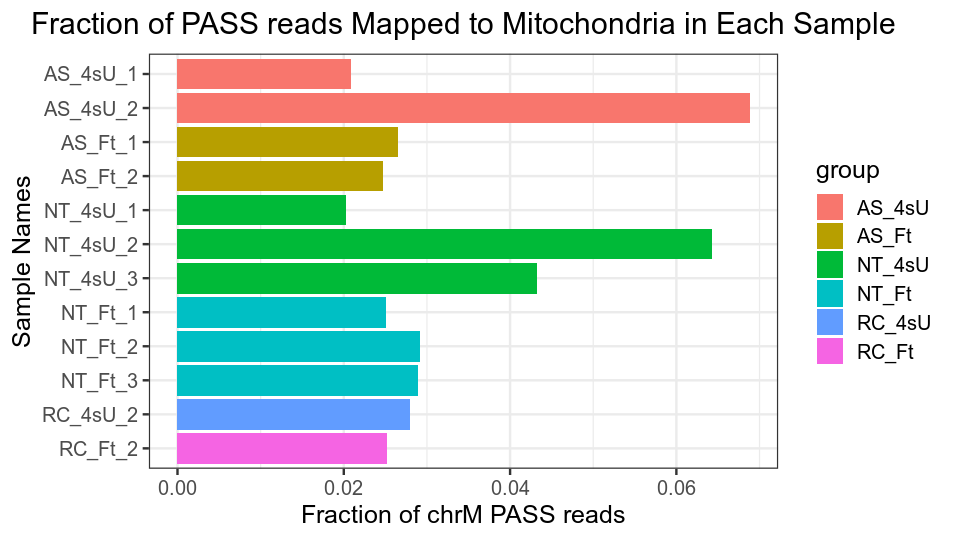

In [21]:
# Change plot size 
options(repr.plot.width=8, repr.plot.height=0.3*(3+nrow(df)))

p

Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

png 
  2

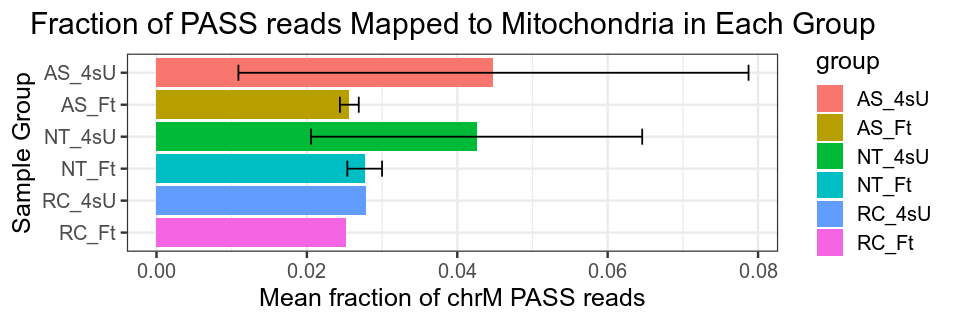

In [22]:
# Calculate mean and sd of chrM fractions
if(length(batches) > 1){
  sum_df = df %>%
    group_by(group) %>%
    summarise(chrM_mean_fraction = mean(chrM_fraction), 
              chrM_fraction_sd = sd(chrM_fraction)) %>%
    ungroup()
  
  p = ggplot(sum_df, aes(x = group, y = chrM_mean_fraction, fill = group)) +
    geom_col() +
    geom_errorbar(aes(x = group, 
                      ymin = chrM_mean_fraction-chrM_fraction_sd, 
                      ymax = chrM_mean_fraction+chrM_fraction_sd), 
                  width = 0.5) + 
    coord_flip() +
    scale_x_discrete(limits = rev(sum_df$group)) +
    xlab("Sample Group") +
    ylab("Mean fraction of chrM PASS reads") +
    ggtitle("Fraction of PASS reads Mapped to Mitochondria in Each Group")
  
  options(repr.plot.width=8, repr.plot.height=0.3*(3+length(unique(sum_df$group))))
  p
}


if(length(batches) > 1){
  png(file.path(result_dir, "mean_chrM_reads_fraction.png"), 100*nrow(sum_df), 500)
  print(p)
  dev.off()
}

Set the "region" of intergenic pAs mapped to the mitochondria genome to "chrM":

In [23]:
pA[pA$region == "intergenic" & seqnames(pA) == "chrM"]$region = "chrM"

## 8. Resolve pA sites mapped to multiple genomic features of the same gene
pA sites can be mapped to multiple genomic features of the same gene due to alternative splicing. By default, the region annotation is simplified unless specified otherwise.

In [24]:
# Fix pAs mapped to multiple features
if(!exists("simplify_region_annotation") || simplify_region_annotation){
  pA$region[grepl("\\|intron$", pA$region)] = "intron"
  pA$region[grepl("\\|CDS$", pA$region)] = "CDS"
  pA$region[grepl("\\|5UTR$", pA$region)] = "5UTR"
}

## 9. Plot summarised distribution of pA sites and reads in genomic features in each sample.
First, summarize pA sites and read numbers in each genomic features in each sample. pA sites with less than *min_count_* in the sample are omitted. The results are saved in an Excel file.

In [25]:
require(scales)
require(openxlsx)

min_count_ = 5 # Read count filter

df = mcols(pA)[, c("region", sample_names)]

# Collapse pAs mapped to multiple features
df$region[grepl("\\|intron$", df$region)] = "intron"
df$region[grepl("\\|CDS$", df$region)] = "CDS"
df$region[grepl("\\|5UTR$", df$region)] = "5UTR"

# Change region names so that they can be used as column names
df$region[df$region == "3UTR"] = "UTR3"
df$region[df$region == "5UTR"] = "UTR5"


# Initialize counting matrixes
region_summary = matrix(nrow = 0, ncol = length(names(table(df$region))))
colnames(region_summary) = names(table(df$region))

read_summary = matrix(ncol = 0, nrow = length(names(table(df$region))))
rownames(read_summary) = names(table(df$region))


# Go through each sample, filter out pAs with low read numbers, and summarize
for(sample_name in sample_names){
  df_ = df[, c("region", sample_name)]
  df_ = df_[df_[, sample_name] >= min_count_, ]
  
  # Summarize numbers of pA site
  region_summary = rbind(region_summary, table(df_$region))
  
  # Summarize read numbers 
  col = group_by(as.data.frame(df_), region) %>%
    summarize_at(vars(sample_name), sum)
  read_summary = cbind(read_summary, col[, sample_name])
  
}

# Add row names and reorder rows
rownames(region_summary) = sample_names
region_summary = region_summary[order(rownames(region_summary)),]
region_summary = t(region_summary)

# Write to Excel
wb = createWorkbook()
addWorksheet(wb, "pA_region_summary")
writeData(wb, sheet = 1, region_summary, rowNames = T)
addWorksheet(wb, "pA_read_summary")
writeData(wb, sheet = 2, read_summary, rowNames = T)
suppressWarnings(saveWorkbook(wb, 
                              file.path(result_dir, "pA_region_and_read_summary.xlsx"),
                              overwrite = TRUE))

Loading required package: scales
Loading required package: zip

Attaching package: ‘zip’

The following objects are masked from ‘package:utils’:

    unzip, zip

Loading required package: openxlsx
Note: zip::zip() is deprecated, please use zip::zipr() instead


Plot distribution of pA sites. The ggplotly() function from the plotly library converts static ggplot2 figures into interactive figures.

In [26]:
# Plotting
region_summary = as.data.frame(region_summary)
region_summary$region = rownames(region_summary)
region_summary = gather(region_summary, key=Sample, value=num_pA, -region)
region_summary$region = factor(region_summary$region, 
                               levels = c("intergenic", "chrM", "ncRNA", "UA", 
                                          "UTR5", "CDS", "intron", "UTR3"))

p = ggplot(data=region_summary, aes(x=Sample, y=num_pA, fill = region)) + 
  geom_col(position = "fill") + 
  scale_y_continuous(labels = percent_format()) +
#   scale_x_discrete(limits = rev(region_summary$Sample)) +
  ylab("Percentage of pA sites") +
  coord_flip() +
  ggtitle("Percentage of pA Sites in Each Sample")

png(file.path(result_dir, "num_pA_summary.png"), 800, length(sample_names)*50)
print(p)
dev.off()

# ggplotly(p) # Uncomment this if you want to see interactive plots.

png 
  2

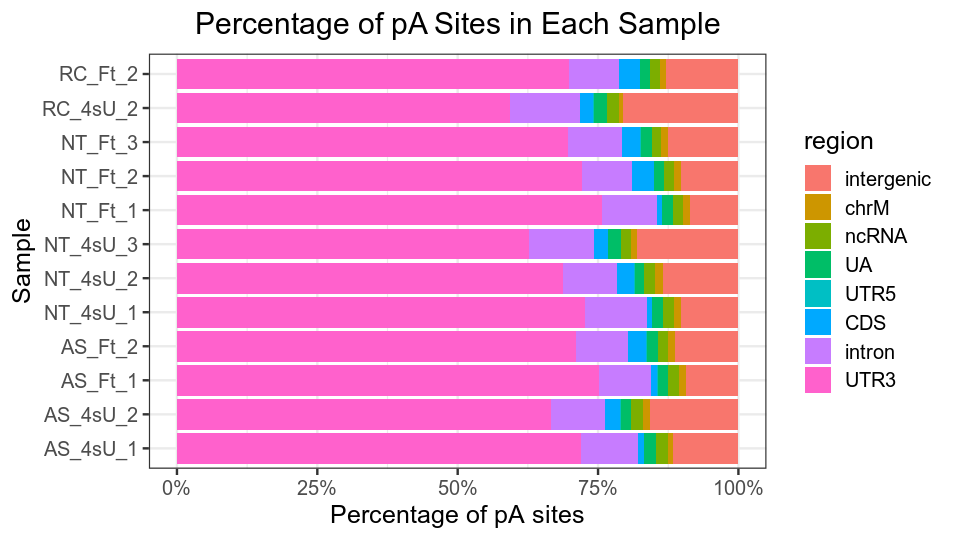

In [27]:
# Change plot size 
library(repr)
options(repr.plot.width=8, repr.plot.height=(length(sample_names)+3)*0.3)
p

Plot distribution of PASS reads. The ggplotly() function from the plotly library converts static ggplot2 figures into interactive figures.

In [28]:
read_summary = as.data.frame(read_summary)
read_summary$region = rownames(read_summary)
read_summary = gather(read_summary, key=Sample, value=num_read, -region)
read_summary$region = factor(read_summary$region, 
                             levels = c("intergenic", "chrM", "ncRNA", "UA",
                                        "UTR5", "CDS", "intron", "UTR3"))

p = ggplot(data=read_summary, aes(x=Sample, y=num_read, fill = region)) + 
  geom_col(position = "fill") + 
  scale_y_continuous(labels = percent_format()) +
#   scale_x_discrete(limits = rev(read_summary$Sample)) +
  ylab("Percentage of PASS reads") +
  coord_flip() +
  ggtitle("Percentage of PASS reads in Each Sample")

png(file.path(result_dir, "num_read_summary.png"), 800, length(sample_names)*50)
print(p)
dev.off()

# ggplotly(p) # Uncomment this if you want to see interactive plots.

png 
  2

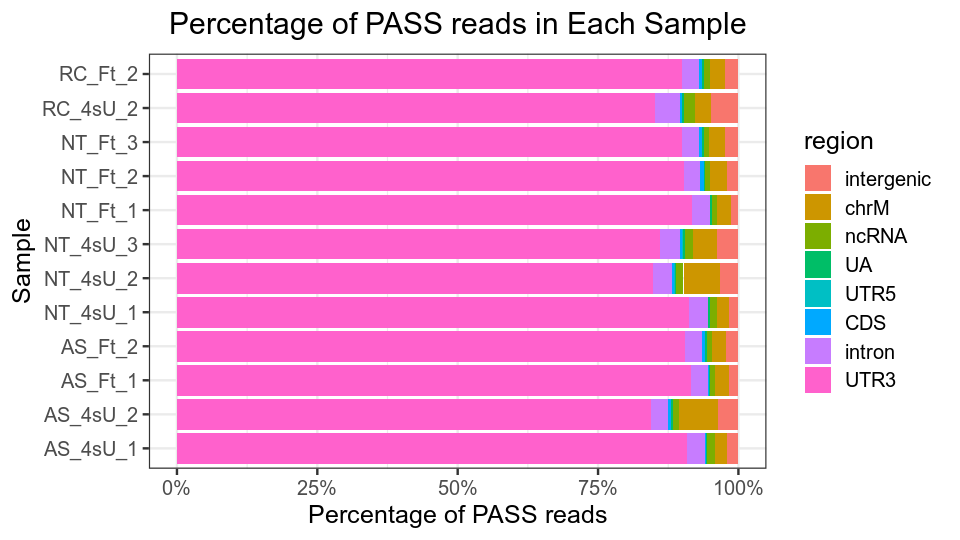

In [29]:
p

## 10. Plot nucleotide profile near pA sites

In [30]:
plot_nucleotide_profile = function(pA, 
                                   BSgeno = "BSgenome.Hsapiens.UCSC.hg19", 
                                   window_size = 100){
         #` A function for plotting nucleotide profile near pAs                                                
         require(GenomicRanges)                                                             
         require(BSgeno, character.only = T)                                                
         require(tidyr)                                                                     
         require(dplyr)                                                                     
         require(ggplot2)                                                                   
                                                                                            
         # Get genomic sequences                                                            
         seq = getSeq(eval(parse(text=BSgeno)), pA + window_size)                           
                                                                                            
         # Remove sequences with "N"                                                        
         seq = seq[!grepl("N", seq)]                                                        
                                                                                            
         # Computes the consensus matrix of a set of sequences                              
         m = consensusMatrix(seq)[1:4,]                                                     
                                                                                            
         # Normalization                                                                    
         m = scale(m, center = F, scale = colSums(m))                                       
                                                                                            
         # Column names indicates position relative to pA                                   
         colnames(m) = -window_size:window_size                                             
                                                                                            
         df = as.data.frame(t(m))                                                           
         df$Position = as.numeric(rownames(df))                                             
         
         p = df %>%                                                                         
           gather(key="Base", value = "Fraction", -Position) %>%                            
           ggplot(aes(x=Position, y=Fraction, color=Base)) +                                
           geom_line() +
           xlab("Position Relative to pA Site")
                                                                                    
         p                                                                                  
  }

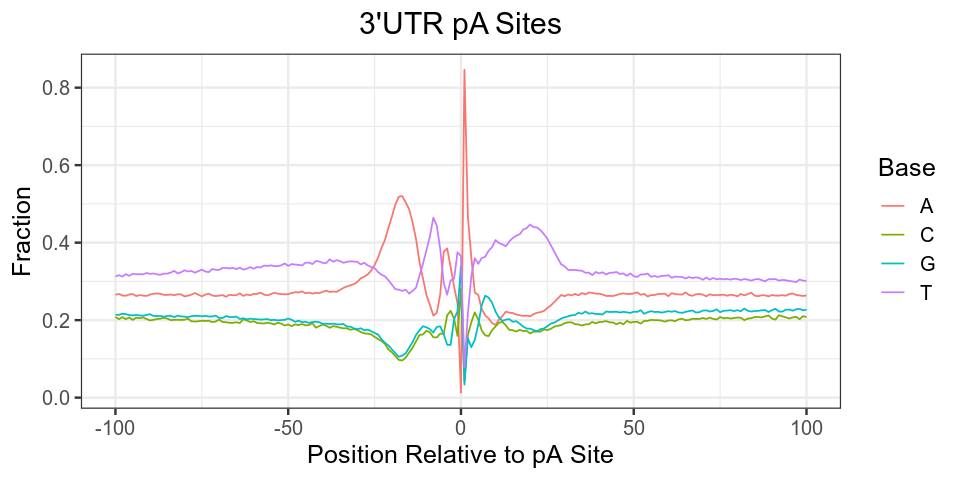

In [31]:
options(repr.plot.width=8, repr.plot.height=4)
plot_nucleotide_profile(pA[pA$region == "3UTR"], BSgeno) + ggtitle("3'UTR pA Sites")

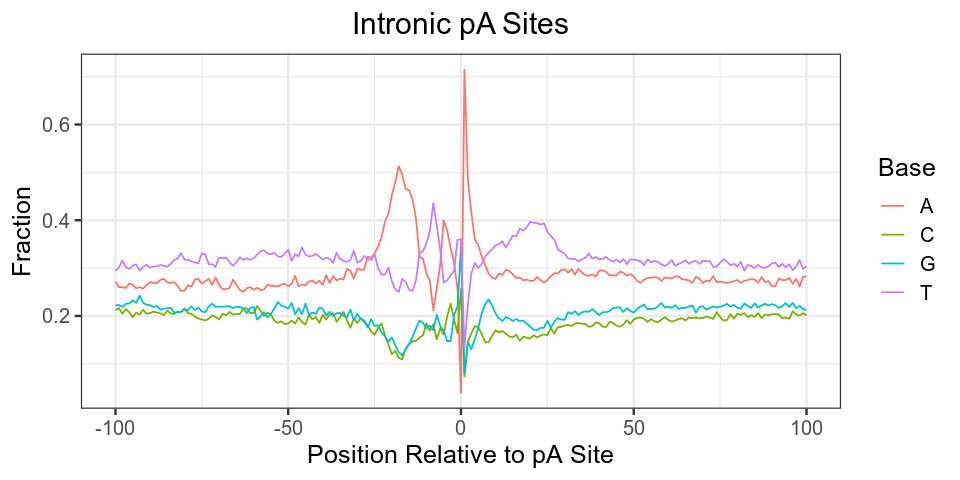

In [32]:
plot_nucleotide_profile(pA[pA$region == "intron"], BSgeno) + ggtitle("Intronic pA Sites")

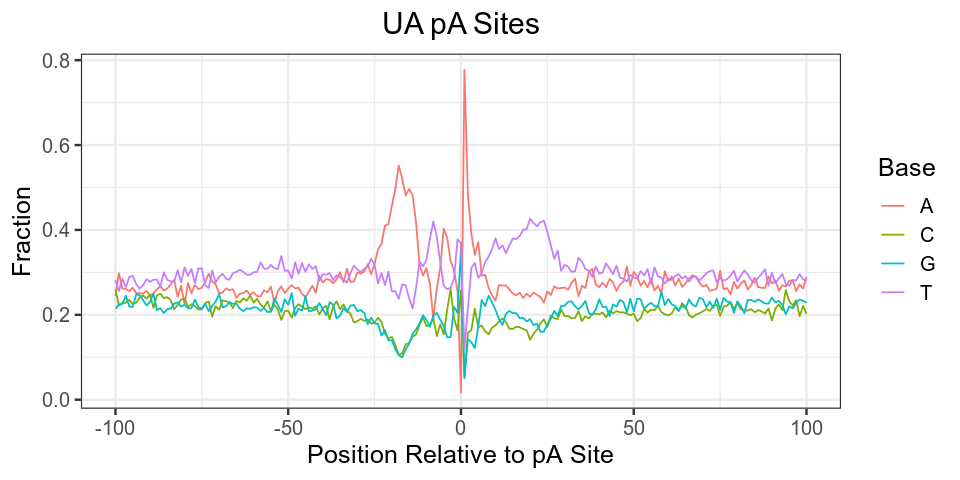

In [33]:
plot_nucleotide_profile(pA[pA$region == "UA"], BSgeno) + ggtitle("UA pA Sites")

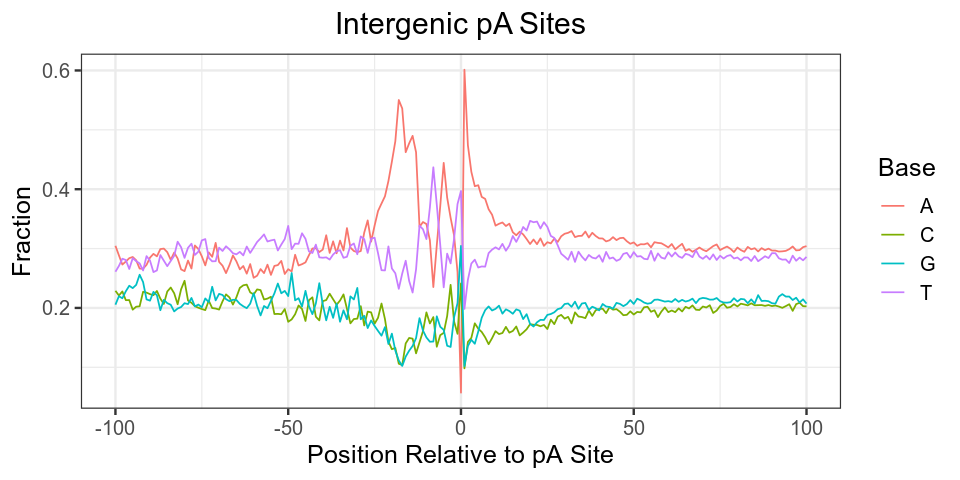

In [34]:
plot_nucleotide_profile(pA[pA$region == "intergenic"], BSgeno) + ggtitle("Intergenic pA Sites")

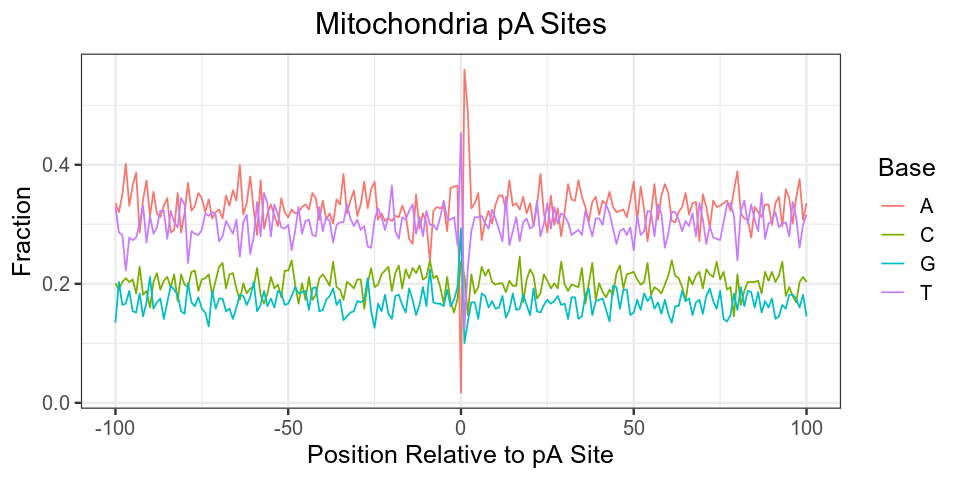

In [35]:
plot_nucleotide_profile(pA[pA$region == "chrM"], BSgeno) + ggtitle("Mitochondria pA Sites")

From the above plots, **we can see that 3'UTR, intronic, and UA pA sites have similar nucleotide profiles around the pA sites, while intergenice and mitochondria pA sites have nucleotide profiles different from regular pA sites.**

# 11. Calculate optimal transcript starting sites (TSSs) 
For genes with >1 UA pA sites and >1 TSSs, use the TSS closest to the most downstream UA pA site, otherwise only keep the most upstream TSS.

In [36]:
# Get TSS 
tss = promoters(txdb, upstream=0, downstream=1, columns=c("tx_name", "gene_id"))

# Convert the accession numbers of the genes into gene symbols
tss$gene_symbol = mapIds(org.db, keys = as.character(tss$tx_name),
                         keytype =  "ACCNUM", column =  "SYMBOL")

# Only consider detected genes
tss = tss[tss$gene_symbol %in% pA$gene_symbol]

# Remove duplicates (One gene can have multiple transcripts with the same TSS)
tss = data.frame(chr = seqnames(tss), strand = strand(tss), 
                 position = start(tss), gene_symbol = tss$gene_symbol)
tss = unique(tss)
tss$gene_symbol = as.vector(tss$gene_symbol)

# Calculate signed position for later use 
pA$signed_position = start(pA) * ifelse(strand(pA) == "+", 1, -1)
tss$signed_position = tss$position * ifelse(tss$strand == "+", 1, -1) 

# Split tss into two categories and treat them differently
tss_with_ua = tss[tss$gene_symbol %in% pA[pA$region == "UA"]$gene_symbol, ]
tss_without_ua = tss[!tss$gene_symbol %in% pA[pA$region == "UA"]$gene_symbol, ]

# Loop through genes in tss_with_ua, select the most reasonable TSS for each gene
tss_with_ua_new = data.frame()
for(gene in unique(tss_with_ua$gene_symbol)){
  tss_for_gene = subset(tss_with_ua, gene_symbol == gene)
  if(nrow(tss_for_gene) == 1){
    tss_with_ua_new = rbind(tss_with_ua_new, tss_for_gene)
  }else{
    # Determine the most reasonable UA pA sites: 
    # pick the UA pA sites upstream to all other UA pA sites
    ua_pA = pA[pA$gene_symbol == gene & pA$region == "UA"] # may have >1 rows
    # ua_pA$signed_position is negative if the gene is on positive strand!
    ua_pA = ua_pA[order(ua_pA$signed_position), ][1,] 
    # tss must be down stream of UA pA site 
    tss_for_gene = tss_for_gene[-ua_pA$signed_position - tss_for_gene$signed_position < 0,]
    # Select the tss closest to the UA pA site
    tss_for_gene = tss_for_gene[which.max(-ua_pA$signed_position - 
                                          tss_for_gene$signed_position),]
    tss_with_ua_new = rbind(tss_with_ua_new, tss_for_gene)
  }
}

# For tss without detected ua pA sites, simply pick the most upstream one
tss_without_ua = tss_without_ua[order(tss_without_ua$gene_symbol, 
                                      tss_without_ua$signed_position), ]
tss_without_ua = split(tss_without_ua, f=tss_without_ua$gene_symbol)
tss_without_ua = do.call(rbind, lapply(tss_without_ua, function(x) x[1,]))
                                       
# Combine the two data frame
tss = rbind(tss_with_ua_new, tss_without_ua)
df = data.frame(gene_symbol = as.vector(pA$gene_symbol))
                                       
# Unmatched rows will be put at the end of the merged table
df = merge(df, tss, by = "gene_symbol", all.x=T, sort=F)
                                       
# Cannot assume that the order remain the same even after setting sort = F
pA = pA[order(pA$gene_symbol)] 
df = df[order(df$gene_symbol),]
pA$tss_position = df$position

rm(tss)
rm(df)

'select()' returned 1:1 mapping between keys and columns


## 12.1. Calculate CDS features for the transcript with the longest CDS for each gene
Due to alternative splicing, some genes can have multiple transcripts with different CDS. This step will find the transcript with longest CDS. If there are ties, the transcript will be selected randomly.

In [37]:
# Calculate CDS features of the transcript with maximum CDS length for each gene
cds = suppressWarnings(cdsBy(txdb, by="tx", use.names=T))

# Calculate total CDS length for each transcript
cds_length = foreach(i=1:length(cds), .combine = "c") %dopar%{
  sum(width(cds[i]))
}

# Split by gene symbols
cds_length = split(cds_length, mapIds(org.db, keys = names(cds_length), 
                                      keytype =  "ACCNUM", column =  "SYMBOL"))

# Get transcripts with longest CDS
max_cds_tx_name = names(sapply(cds_length, which.max))
max_cds_tx_name = sub("^.+\\.", "", max_cds_tx_name) 

# Get CDS sequence
maxCDS_seq = getSeq(eval(parse(text = BSspec)), cds[max_cds_tx_name])
maxCDS_seq = lapply(maxCDS_seq, function(x) unlist(x))
maxCDS_seq = DNAStringSet(maxCDS_seq)
                    
# Calculate base frequency
base_fraction = alphabetFrequency(maxCDS_seq, baseOnly=T, as.prob=T)
                    
CDS_features = data.frame(maxCDS_tx= names(maxCDS_seq), 
                          cds_start = unlist(start(range(cds[max_cds_tx_name]))),
                          cds_end = unlist(end(range(cds[max_cds_tx_name]))),
                          CDS_size = width(maxCDS_seq), 
                          CDS_GC = base_fraction[, "C"] + base_fraction[, "G"],
                          stringsAsFactors = F)
                    
CDS_features$gene_symbol =  mapIds(org.db, keys = CDS_features$maxCDS_tx, 
                                   keytype =  "ACCNUM", column =  "SYMBOL")

'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


## 12.2. Calculate intron features for the transcript with longest CDS of each gene

In [38]:
# Calculate features of introns of the longest CDS transcript
introns = suppressWarnings(intronsByTranscript(txdb, use.names=T))

introns = introns[names(introns) %in% CDS_features$maxCDS_tx]

intron_sizes = lapply(introns, function(intron) width(intron))
                      
# Remove NULL or 0-length introns                      
mask = sapply(intron_sizes, function(intron) length(intron) > 0)
introns = introns[mask]
intron_sizes = intron_sizes[mask]

intron_features = data.frame(maxCDS_tx = as.character(names(introns)), 
                             max_intron_size = sapply(intron_sizes, max), 
                             min_intron_size = sapply(intron_sizes, min),
                             total_intron_size = sapply(intron_sizes, sum),
                             num_intron = sapply(intron_sizes, function(sizes) sum(sizes > 0)),
                             stringsAsFactors = F)
                                                 
intron_features[intron_features %in% c(Inf, -Inf)] = 0

## 12.3. Calculate 5'UTR features for the transcript with longest CDS of each gene

In [39]:
# Calculation features of 5'UTRs of the longest CDS transcript
UTR5 = suppressWarnings(fiveUTRsByTranscript(txdb, use.names=T))
UTR5 = UTR5[names(UTR5) %in% CDS_features$maxCDS_tx]

UTR5_seq = getSeq(eval(parse(text = BSspec)), UTR5)
UTR5_seq = lapply(UTR5_seq, function(x) unlist(x))
UTR5_seq = DNAStringSet(UTR5_seq)
                  
base_fraction = alphabetFrequency(UTR5_seq, baseOnly=T, as.prob=T)

UTR5_features = data.frame(maxCDS_tx = names(UTR5), 
                           UTR5_size = sapply(UTR5, function(UTR5) sum(width(UTR5))), 
                           UTR5_GC = base_fraction[, "C"] + base_fraction[, "G"],
                           stringsAsFactors = F)
                           

Predict uORFs in 5'UTRs:

In [40]:
# Predict uORF in 5'UTRs
orf_count = data.frame(gene_symbol = names(UTR5_seq), uORF = 0)

for(gene in names(UTR5_seq)){
  orf = findORFsinSeq(unlist(UTR5_seq[[gene]]))
  if(sum(orf[["lengths"]] > 30, na.rm = T)){
    orf_count[orf_count$gene_symbol == gene, "uORF"] = sum(orf[["lengths"]] > 30)
  }
}

uORF = orf_count$uORF
names(uORF) = orf_count$gene_symbol

pA$uORF = uORF[pA$gene_symbol]

## 12.4. Calculate non-coding RNA (ncRNA) features
*ncTx* was created in Step 5 when mapping pAs to non-coding RNAs.

In [41]:
# Get exonic sequence
ncRNA_seq = getSeq(eval(parse(text=BSgeno)), ncTx)

ncRNA_seq = lapply(ncRNA_seq, function(x) unlist(x))
                   
ncRNA_seq = DNAStringSet(ncRNA_seq)
                   
# Calculate GC content
base_fraction = alphabetFrequency(ncRNA_seq, baseOnly=T, as.prob=T)
ncRNA_features = data.frame(gene_symbol = names(ncRNA_seq), 
                            ncRNA_size = width(ncRNA_seq), 
                            ncRNA_GC = base_fraction[, "C"] + base_fraction[, "G"],
                            stringsAsFactors = F)

## 12.5. Combine 5'UTR, CDS, intron, and ncRNA features with pA sites in a dataframe
The *pas* dataframe will be mentioned a lot in downstream analysis. **pas** means **p**oly**a**denylation **s**ites. 

In [42]:
# Conver the GRanges into a dataframe for further calculation
pas = cbind(data.frame(chr = seqnames(pA), strand = strand(pA), pA_pos = start(pA)), 
              data.frame(mcols(pA)))
pas$pAid = with(pas, paste0(chr, strand, pA_pos))

utr3 = pas %>%
  dplyr::filter(region == "3UTR") %>%
  left_join(CDS_features, by = "gene_symbol") %>%
  left_join(UTR5_features, by = "maxCDS_tx") %>%
  left_join(intron_features, by = "maxCDS_tx") 

other = pas %>%
  dplyr::filter(region != "3UTR") %>%
  left_join(ncRNA_features, by = "gene_symbol")
  
pas = bind_rows(utr3, other)

pas[pas$region == "ncRNA", ]$tx_size = pas[pas$region == "ncRNA", ]$ncRNA_size 

rm(CDS_features, intron_features, UTR5_features, ncRNA_features)

Warning message in `[<-.data.frame`(`*tmp*`, pas$region == "ncRNA", , value = structure(list(:
“provided 35 variables to replace 34 variables”

## 12.6. Calculate exonic 3'UTR sequence, GC content, size, transcript size, and gene_size
Some 3'UTRs contain introns. To get only exonic 3'UTR sequences, I first get genomic sequences between CDS ends and the pA sites for all the pA sites, then update sequences for 3'UTRs containing introns that do not overlap with any annotated 3'UTRs.

In [43]:
geno = eval(parse(text = BSspec))

# Create 3'UTR GRanges for pAs mapped to 3'UTRs, introns included      
pA_3UTR = create_3UTRs_from_pAs(pas) 

# Get genomic sequence for the 3'UTRs, without removing intronic sequences
pA_3UTR$exonic_3UTR_seq = as.character(getSeq(geno, pA_3UTR))

# Remove introns mapped to >1 strands
introns = suppressWarnings(intronsByTranscript(txdb, use.names=T))
introns = rename_grl(introns, old_key = "ACCNUM", new_key = "SYMBOL")
introns = unlist(introns)

# Remove 3pUTRs mapped to >1 strands
threeUTRs = suppressWarnings(threeUTRsByTranscript(txdb, use.names=T))
threeUTRs = rename_grl(threeUTRs, old_key = "ACCNUM", new_key = "SYMBOL")
threeUTRs = unlist(threeUTRs)

rm(txdb)

# Only keep intronic regions not overlapping with any annotated 3'UTRs
introns = setdiff(introns, threeUTRs)

# Make a list to work on individual 3'UTR containing introns
pA_3UTR_lst = split(pA_3UTR, pA_3UTR$pAid)
olp = findOverlaps(introns, pA_3UTR_lst, type = "within")

# Record which 3'UTRs contain introns
pA_3UTR$has_intron = F
pA_3UTR[subjectHits(olp), ]$has_intron = T

# Remove intron from each 3'UTR, then get genomic sequence
pA_3UTR[subjectHits(olp), ]$exonic_3UTR_seq = sapply(1:length(olp), function(i) {
  gr = setdiff(pA_3UTR_lst[[subjectHits(olp[i])]], introns[queryHits(olp[i])])   
  as.character(unlist(getSeq(geno, gr)))
  }
)

# Report how many introns have been removed from how many 3'UTRs
cat(length(unique(queryHits(olp))), "introns were removed from", 
    length(unique(subjectHits(olp))), "3'UTRs.")

# Calculate 3'UTR GC content
utr3_seq = DNAStringSet(pA_3UTR$exonic_3UTR_seq)
base_fraction = alphabetFrequency(utr3_seq, baseOnly=T, as.prob=T)
pA_3UTR$UTR3_GC = base_fraction[, "C"] + base_fraction[, "G"]
pA_3UTR$UTR3_size = width(utr3_seq)

# Add the 3'UTR features to pas data frame
pas = merge(pas, 
            as.data.frame(mcols(pA_3UTR)[, c("pAid", "exonic_3UTR_seq", 
                                             "UTR3_GC", "UTR3_size", "has_intron")]), 
            all.x=T, sort=F)

# Calculate transcript size
pas$tx_size = rowSums(pas[, c("UTR5_size", "CDS_size", "UTR3_size")])

# Gene_size is the distance between pA site and TSS
pas$gene_size = abs(pas$pA_pos - pas$tss_position)
pas$gene_size = ifelse(pas$region == "UA", -1*pas$gene_size, pas$gene_size)

'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


532 introns were removed from 1263 3'UTRs.

## 12.7 Check correlations among 5'UTR, CDS, and 3'UTR GC content
I divided transcripts into 3 groups based on their CDS sizes and then I checked if 5'UTR, CDS, and 3'UTR GC content for the transcripts are correlated.

Loading required package: GGally
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa



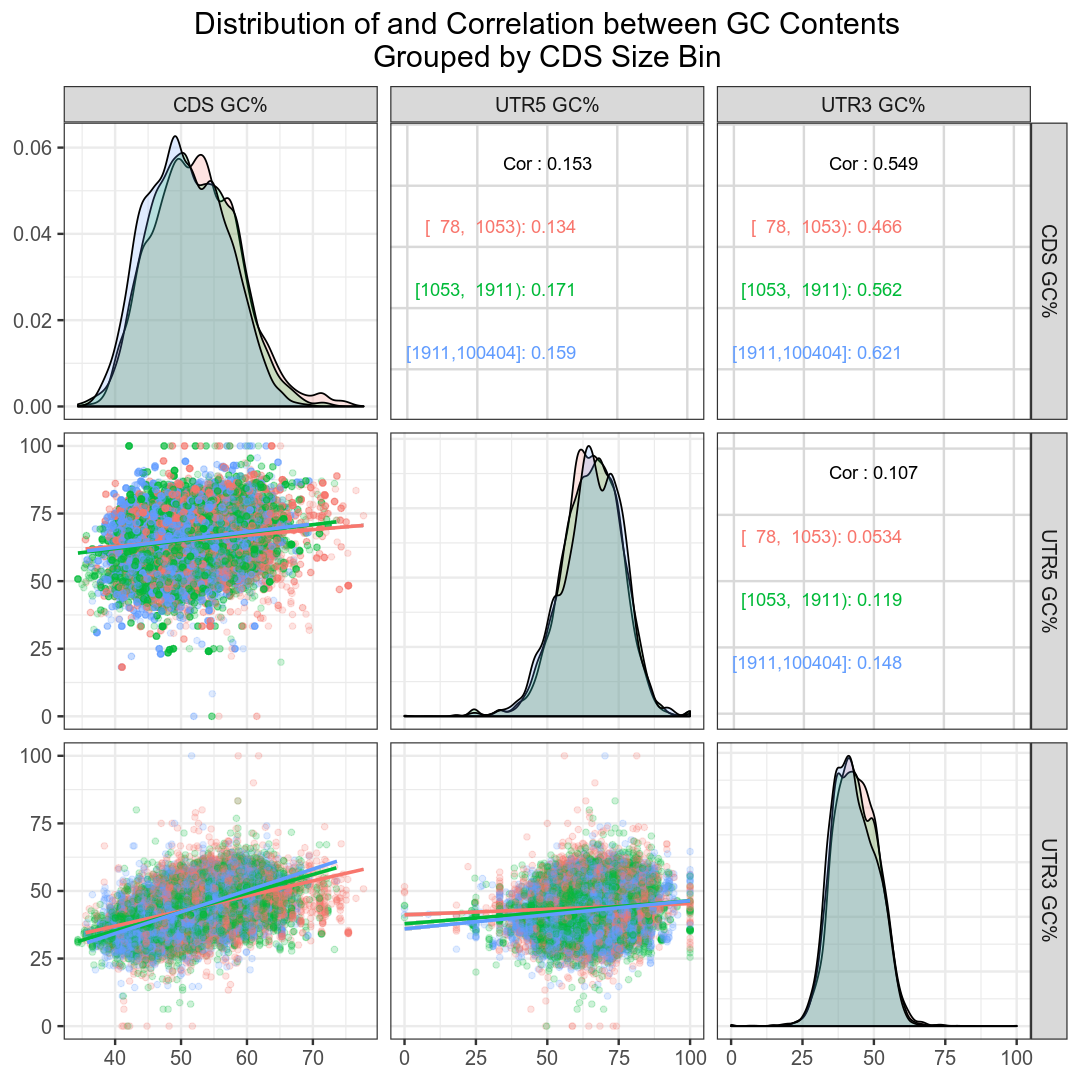

In [44]:
options(repr.plot.width=9, repr.plot.height=9)
oldw = getOption("warn")
options(warn = -1)

df = pas[, grep("^[^n][^c].+_GC|CDS_size", names(pas))] %>%
  distinct() %>%
  mutate(CDS_size = Hmisc::cut2(CDS_size, g=3)) %>%
  mutate_at(vars(matches("_GC")), list(~.*100))

names(df) = sub("_GC", " GC%", names(df))

require(GGally)
ggpairs(df, columns = grep("GC", names(df)),
        ggplot2::aes(color=CDS_size),
        lower = list(continuous = wrap("smooth", alpha = 0.2)),
        diag = list(continuous = wrap("densityDiag", alpha = 0.2)),
        title = "Distribution of and Correlation between GC Contents\nGrouped by CDS Size Bin")


options(warn=oldw)

From the above plot we can see that **while CDS GC% and 3'UTR GC% are quite strongly correlated, 5'UTR GC% is almost not correlated with CDS GC% or 3'UTR GC%. Moreover, the correlation patterns are the same for transcripts with different CDS sizes.**

## 13. Identify subtypes of pA sites.
Just to follow conventions, 3'UTR pA sites are further classified into "S" (Single), "F" (First), "M" (Middle), and "L" (Last) subtypes. 5'UTR and CDS pA sites are combined into "E" type. 

In [45]:
# Calculate pA_type
pas$pA_type = ifelse(grepl("intron", pas$region), "I", 
                       ifelse(grepl("CDS|5UTR", pas$region), "E", 
                              ifelse(pas$region == "UA", "UA",
                                     ifelse(pas$region == "chrM", "chrM",
                                            ifelse(pas$region == "intergenic", "Intergenic",
                                                   "SFML"))))) # ncRNA may also have SFML types

pas$pA_type[table(pas$gene_symbol)[pas$gene_symbol] == 1 & pas$pA_type == "SFML"] = "S"

pas$signed_pA_pos = pas$pA_pos * ifelse(pas$strand == "+", 1, -1)

tmp = dplyr::filter(as.data.frame(pas), pA_type == "SFML") %>%
  group_by(gene_symbol) %>%
  mutate(percrank=percent_rank(signed_pA_pos))

tmp$pA_type = ifelse(tmp$percrank == 0, "F", 
                     ifelse(tmp$percrank == 1, "L", "M"))

pas = rbind(pas[pas$pA_type != "SFML",], as.data.frame(tmp[, -grep("percrank", names(tmp))]))

pas = as.data.frame(pas) %>% 
      group_by(gene_symbol) %>%
      arrange(signed_pA_pos)

pas = as.data.frame(pas)

rm(tmp)

## 14. Calculate poly(A) signal (PAS) using the 40 nt sequence upstream of pA sites

In [46]:
# Calculate PAS using the 40 nt sequence upstream of pA
motifcounts = countAllMotif(pas, geno = GENOME, search_from = 0, 
                            search_len = 40, motif_width = 6)

PASs = c("AATAAA", "ATTAAA", "AGTAAA", "TATAAA", "CATAAA", "GATAAA", "AATATA", "AATACA", 
         "AATAGA", "AAAAAG", "ACTAAA", "AAAAAA")

motifcounts = motifcounts[, PASs]

PAScounts = cbind(motifcounts[, PASs[1:2]], 
                  OtherPAS = rowSums(motifcounts[, PASs[3:(length(PASs) -1)]]),
                  Arich = motifcounts[, "AAAAAA"])

PAScounts = as.data.frame(PAScounts)

pas$PAS = ifelse(PAScounts$AATAAA > 0, "AATAAA", 
                   ifelse(PAScounts$ATTAAA > 0, "ATTAAA",
                          ifelse(PAScounts$OtherPAS > 0, "OtherPAS",
                                 ifelse(PAScounts$Arich > 0, "Arich", "NoPAS"))))
rm(motifcounts)
rm(PAScounts)

## 15. Check if different subtypes of pA sites tend to use different PAS (poly(A) signal)

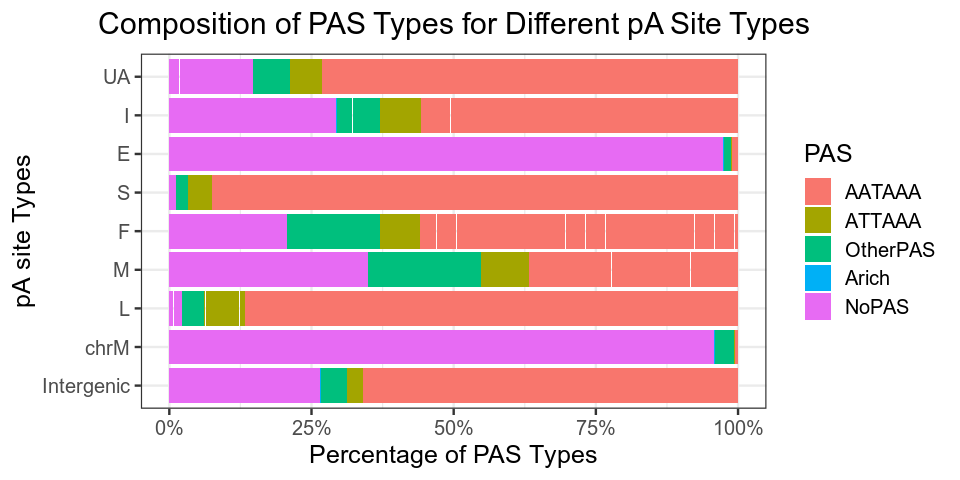

In [47]:
options(repr.plot.width=8, repr.plot.height=4)

pas %>% 
  dplyr::select(pA_type, PAS) %>%
  drop_na() %>% 
  group_by(pA_type, PAS) %>%
  mutate(count = n()) %>%
  ungroup() %>%
  mutate(pA_type = factor(pA_type, levels = rev(c("UA", "I", 'E', "S", "F", "M", "L",  
                                                  "ncRNA", "chrM", "Intergenic")))) %>%
  mutate(PAS = factor(PAS, levels = c("AATAAA", "ATTAAA", "OtherPAS", "Arich", "NoPAS"))) %>%
  ggplot(aes(x = pA_type, y = count, fill = PAS)) +
  geom_col(position = "fill") + 
  scale_y_continuous(labels = percent_format()) +
  ylab("Percentage of PAS Types") +
  xlab("pA site Types") +
  ggtitle("Composition of PAS Types for Different pA Site Types") +
  coord_flip() 

From the above plot, it seems that **pA sites mapped to mitochondria (chrM) and CDS or 5'UTRs (E) tend to have no obvious PAS. On the other hand, UA and intergenic pA sites also have PAS similar to 3'UTR pA sites (especially S (single pA site per gene) and L (last 3'UTR pA sites in APA 3'UTRs)). Compared with L pA sites, F (first pA sites in APA 3'UTRs) and M (middle pA sites in APA 3'UTRs) sites tend to have more weaker PAS.**

## 16. Add gene description and gene id

In [59]:
# Add gene_symbol and gene_id using org.x.db
pas$gene_id = as.numeric(mapIds(org.db, keys = pas$gene_symbol, 
                                keytype =  "SYMBOL", column =  "ENTREZID"))

pas$description = mapIds(org.db, keys = pas$gene_symbol, 
                         keytype = "SYMBOL", column = "GENENAME")

'select()' returned 1:many mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


## 17.1. Calculate RPM (Reads Per Million) for each pA site
To reduce the effect of extreme values when calculating RPM, only sum up read numbers between 0.5 and 0.95 quantile. UA reads and intergenic reads will not be included when calculating total reads numbers.

In [48]:
# Calculate RPM, using total reads 
for(sample_name in sample_names){
  # only use genic reads
  all_counts = pas[pas$gene_symbol != "Unknown", sample_name] 
  # between 0.5 and 0.95 quantile
  range = quantile(all_counts, c(0.05, 0.95))
  trimmed_counts = all_counts[all_counts >= range[1] & all_counts <= range[2]]
    
  pas[,paste0(sample_name, "_rpm")] = 10^6*pas[,sample_name]/sum(trimmed_counts)
}

## 17.2. Total read number per gene, without including reads from UA pA sites

In [49]:
# Calculate total reads number per gene, without counting pAs in UA 
num_per_gene = aggregate(pas[pas$region != "UA" & pas$region != "intergenic", sample_names], 
                         list(gene_symbol = pas[pas$region != "UA" & 
                                                pas$region != "intergenic",]$gene_symbol
                             ), 
                         sum)

names(num_per_gene)[-1] = paste0(names(num_per_gene)[-1], "_gene")

pas = merge(pas, num_per_gene, all.x = T, sort = F)

rm(num_per_gene)

## 17.3. pA site usage (fraction of PASS reads from each pA site among all pA sites of the same gene)

In [53]:
# Calculate pA usage
for(sample_name in sample_names){
  pas[, paste0(sample_name, "_usage")] = 0
    
  pas[pas$region != "UA", paste0(sample_name, "_usage")] = 
      pas[pas$region != "UA", sample_name]*100/
      pas[pas$region != "UA", paste0(sample_name, "_gene")]
}

## 17.4. Total 3'UTR reads and 3'UTR RPMs per gene
Since only transcripts with 3'UTR pA sites can encode the full length protein, total 3'UTR reads can be used to measure gene expression.

In [54]:
#### Calculate total 3'UTR reads per gene
num_in_3utr_per_gene = aggregate(pas[pas$region == "3UTR", sample_names], 
                                 list(gene_symbol= pas[pas$region == "3UTR",]$gene_symbol),
                                 sum)

names(num_in_3utr_per_gene)[-1] = paste0(names(num_in_3utr_per_gene)[-1], "_3utr")

pas = merge(pas, num_in_3utr_per_gene, all.x=T, sort = F)

rm(num_in_3utr_per_gene)

In [55]:
# Calculate total 3'UTR RPMs per gene
rpm_in_3utr_per_gene = aggregate(pas[pas$region == "3UTR", paste0(sample_names, "_rpm")], 
                                 list(gene_symbol= pas[pas$region == "3UTR",]$gene_symbol),
                                 sum)

names(rpm_in_3utr_per_gene)[-1] = paste0(names(rpm_in_3utr_per_gene)[-1], "_3utr")

pas = merge(pas, rpm_in_3utr_per_gene, all.x=T, sort = F)

rm(rpm_in_3utr_per_gene)

# Change column names
colnames(pas) = sub("(_\\d+[a-z]?)$", "\\1_count", colnames(pas))

In [56]:
# Calculate genewise RPM
for(samplename in sample_names){
  all_counts = pas[, paste0(samplename, "_count")]
  range = quantile(all_counts, c(0.05, 0.95))
  trimmed_counts = all_counts[all_counts >= range[1] & all_counts <= range[2]]
  pas[, paste0("Gene_RPM_", samplename)] = 10^6 * pas[, paste0(samplename, "_gene")]/
                                                  sum(trimmed_counts)
}

## 18. Filter out lowly expressed 3'UTR pAs
For downstream analysis, it is necessary to focus on only significantly expressed transcripts. However, I also want to keep lowly expressed transcripts if the pA sites are not in 3'UTR, since they are generally unstable.

In [57]:
# Filter lowly expressed pAs
if(exists("filter_strength")){
  if(filter_strength < 0 | filter_strength > 1){
    stop("filter_strength must be between 0 and 1.")
  }
}else{
  # 0 ~ 1, bigger value means more stringent filtering
  filter_strength = 1/2 
}

filter1 = rowSums(pas[,grepl("_usage$", names(pas))] >= 
          lowest_usage, na.rm = T) >= length(sample_names)*filter_strength
filter2 = rowSums(pas[,grepl("_rpm$", names(pas))] >= lowest_rpm, na.rm = T) >= 
          length(sample_names)*filter_strength
filter3 = rowSums(pas[,grepl("_count$", names(pas))] >= lowest_count, na.rm = T) >= 
          length(sample_names)*filter_strength

# Keep pAs in other genic regions (outside of 3'UTRs)
filter4 = pas$region != "3UTR"
pas = pas[(filter1 & filter2 & filter3)|filter4, ]

## 19. Number of pA sites per gene and its relationship with the GC% of 3'UTR and CDS.
This analysis is done after filtering out lowly expressed pA sites, so that the result is not affected by noise.

In [50]:
# Calculate number of pAs per gene
Num_pA = as.data.frame(table(pas$gene_symbol[pas$gene_symbol != "Unknown"]))

names(Num_pA) = c("gene_symbol", "Num_pA")

pas = merge(pas, Num_pA, by = "gene_symbol", all.x=T, sort=F)

rm(Num_pA)

The nucleotide profile near 3'UTR pA sites are AU-rich (shown in step 10), so I wondered if Genes with GC-rich 3'UTRs tend to have less pA sites:


Attaching package: ‘ggridges’

The following object is masked from ‘package:ggplot2’:

    scale_discrete_manual

Loading required package: viridisLite

Attaching package: ‘viridis’

The following object is masked from ‘package:scales’:

    viridis_pal

Picking joint bandwidth of 1.16


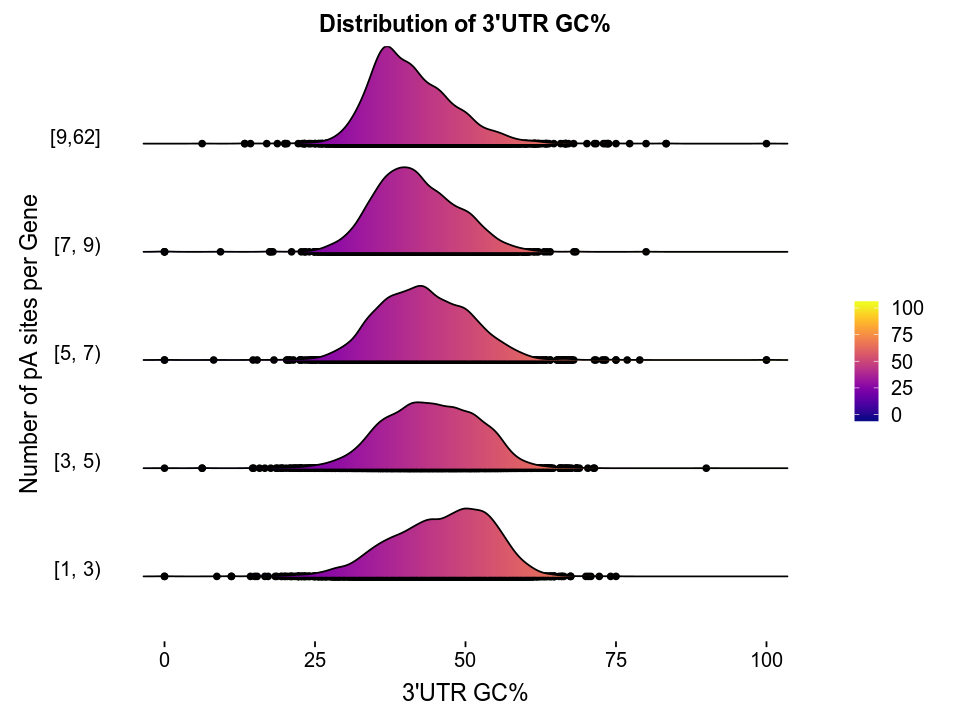

In [51]:
options(repr.plot.width=8, repr.plot.height=6)
library(ggridges)
library(viridis)

df = pas[, grep("^[^n][^c].+_GC|Num_pA", names(pas))] %>%
  distinct() %>%
  drop_na() %>%
  mutate(Num_pA = Hmisc::cut2(Num_pA, g = 5)) %>%
  mutate_at(vars(matches("_GC")), list(~.*100))

p = ggplot(df, aes(x=UTR3_GC, y=Num_pA, fill = ..x..)) +
  geom_point() +
  geom_density_ridges_gradient(scale = 0.9, gradient_lwd = 0.5, color = "black") +
  scale_fill_viridis(option = "plasma", name = "") +
  labs(x = "3'UTR GC%", y = "Number of pA sites per Gene") +
  theme_ridges(grid = F, center_axis_labels = T) +
  theme(plot.title = element_text(hjust = 0.5)) +
  ggtitle("Distribution of 3'UTR GC%")

p


Since the GC% in 3'UTRs and CDSs are correlated (Step 12.7), it is not surprising that genes with GC-rich CDS tend to have fewer poly(A) sites:

Picking joint bandwidth of 0.952


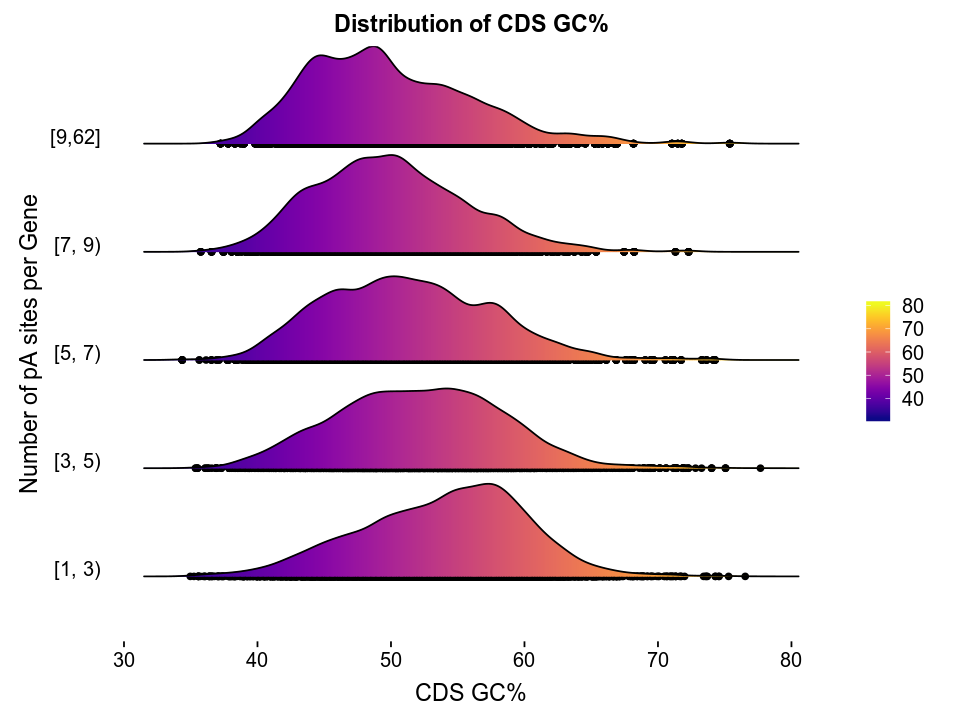

In [52]:
options(repr.plot.width=8, repr.plot.height=6)
library(ggridges)
library(viridis)

df = pas[, grep("^[^n][^c].+_GC|Num_pA", names(pas))] %>%
  distinct() %>%
  drop_na() %>%
  mutate(Num_pA = Hmisc::cut2(Num_pA, g = 5)) %>%
  mutate_at(vars(matches("_GC")), list(~.*100))

p = ggplot(df, aes(x=CDS_GC, y=Num_pA, fill = ..x..)) +
  geom_point() +
  geom_density_ridges_gradient(scale = 0.9, gradient_lwd = 0.5, color = "black") +
  scale_fill_viridis(option = "plasma", name = "") +
  labs(x = "CDS GC%", y = "Number of pA sites per Gene") +
  theme_ridges(grid = F, center_axis_labels = T) +
  theme(plot.title = element_text(hjust = 0.5)) +
  ggtitle("Distribution of CDS GC%")
  
p


## 20. Calculate Minimum Folding Energy (MFE) of exonic 3'UTR sequences
I use a 100-nt sliding window (step size 50 nt) to calculate MFE of exonic 3'UTR sequences within the window. Then the min, median, max, and mean of the MFEs (from the sliding windows) were calcualted for each 3'UTR. 

If the 3'UTR is shorter than 50 nt, the MFE will be NA. If the 3'UTR is between 50 and 100 nt, the MFE will be scaled by sequence length. If the last sliding window is shorter than 100 nt (most cases), the window will be slided back to include the last nucleotide.

The functions for doing the calculation were written in python, because I need to use [ViennaRNA](https://www.tbi.univie.ac.at/RNA/ViennaRNA/doc/html/install.html), which only has python binding. Luckily, it is possible to import python functions into R using the *reticulate* library. 

The [Dask](https://dask.org/) library is used for parallel computing. 

In [11]:
library(reticulate)
use_condaenv("base")

# Source the python function mfe_for_df() from mfe.py

source(file.path(MODULE_DIR, "mfe.py"))
# Calculate MFE using 8 CPUs
pas = mfe_for_df(pas, seq_column="exonic_3UTR_seq", 
                 num_workers=8L, window_size=100L, step_size=50L) # L: integer

write.csv(pas, file.path(result_dir, "pas.csv"), row.names=F)


Attaching package: ‘reticulate’

The following object is masked from ‘package:rtracklayer’:

    import



Confirm that minimal folding energy (MFE) is negatively correlated with 3'UTR GC%:

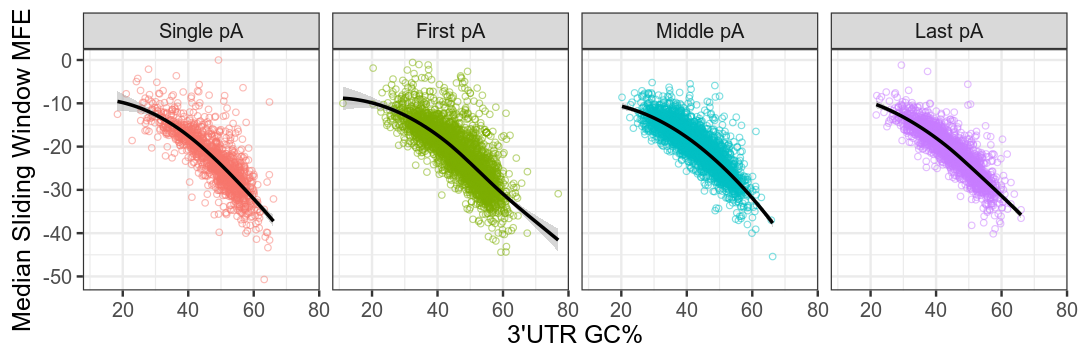

In [61]:
options(repr.plot.width=9, repr.plot.height=3)
p = pas %>%
  mutate(pA_type = sub("S", "Single pA", pA_type)) %>%
  mutate(pA_type = sub("F", "First pA", pA_type)) %>%
  mutate(pA_type = sub("M", "Middle pA", pA_type)) %>%
  mutate(pA_type = sub("L", "Last pA", pA_type)) %>%
  mutate(pA_type = factor(pA_type, levels=c("Single pA", "First pA", "Middle pA", "Last pA"))) %>%
  mutate(UTR3_GC = 100*UTR3_GC) %>%
  dplyr::filter(!is.na(window_mfe_median)) %>%
  ggplot(aes(x=UTR3_GC, y=window_mfe_median, color=pA_type)) +
  geom_point(shape=1, alpha=0.5) +
  geom_smooth(method="loess", color="black", span=0.99) +
  theme(legend.position = "none") +
  facet_grid(~pA_type) +
  xlab("3'UTR GC%") +
  ylab("Median Sliding Window MFE") 

p

3'UTRs of genes with single pA site tend to have lower minimal folding energy (MFE):

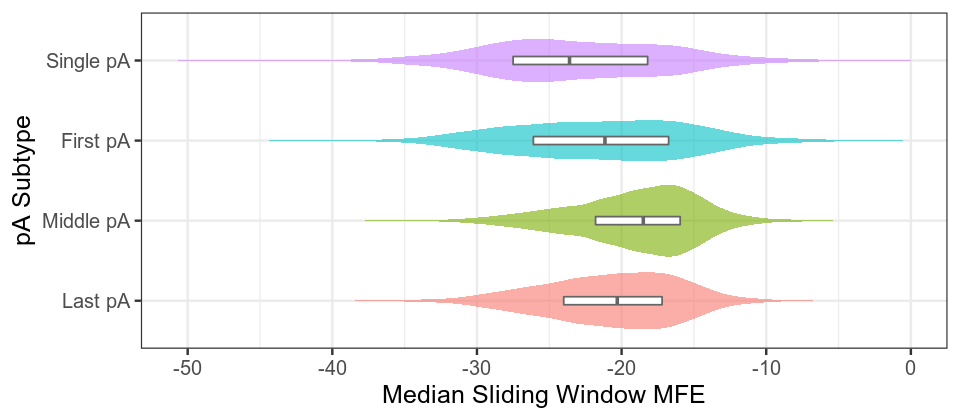

In [12]:
options(repr.plot.width=8, repr.plot.height=3.5)
p = pas %>%
  mutate(pA_type = sub("S", "Single pA", pA_type)) %>%
  mutate(pA_type = sub("F", "First pA", pA_type)) %>%
  mutate(pA_type = sub("M", "Middle pA", pA_type)) %>%
  mutate(pA_type = sub("L", "Last pA", pA_type)) %>%
  mutate(pA_type = factor(pA_type, levels=c("Single pA", "First pA", "Middle pA", "Last pA"))) %>%
  dplyr::filter(!is.na(window_mfe_median)) %>%
  ggplot(aes(y=window_mfe_median, x=pA_type)) +
  geom_violin(aes(fill = pA_type), color = "transparent", alpha = 0.6) +
  geom_boxplot(outlier.alpha = 0, coef = 0, color = "gray40", width = 0.1) +
  scale_x_reverse() +
  xlab("pA Subtype") +
  ylab("Median Sliding Window MFE") +
  theme(legend.position = "none") +
  coord_flip()

p

## 21. Add encoded protein localization
The localization of encoded protein may also impact its mRNA metabolism. For example, mRNAs encoding membrane or secreted proteins tend to localize to the ER membrane. 

If you have not download and process protein localization data before, the pipeline will download protein localization data from http://proteomics.ysu.edu/secretomes/animal/index.php and convert the Uniprot IDs into Gene Symbols using BioMart (slow). The processed data will be saved for future use. 

In [ ]:
if(!file.exists(file.path(SHARED_DATA_DIR, paste0(species, "_protein_locations.csv")))){
    source(file.path(MODULE_DIR, "process_MetazSecKB.R"))
}

Add protein localization to the dataframe:

In [ ]:
add_protein_localization = function(df = pA.df, 
                                    annotation_file = "/home/dinghai/projects/fud/mouse_protein_locations.csv"){
  require(dplyr)
  
  protein_locations = read.csv(annotation_file, as.is = T)
  
  names(protein_locations) = paste0("YSU.", names(protein_locations)) 

  names(protein_locations) = sub("YSU.mgi_symbol", "gene_symbol", names(protein_locations)) 
  
  # The genes not found in protein_locations will be NA
  df = left_join(df, protein_locations) 
  
  # When df is pA.df, pAs in introns, UA, etc should not be annotated with protein localization
  if("region" %in% names(df)){ 
    for(loc in names(protein_locations)[-1]){
      df[df$region != "3UTR", loc] = NA
    }
  }
  
  df
}

## X. Cluster samples using corrrelation between RPMs.
We can have a look at how the samples are correlated, which may help us identify outliers:

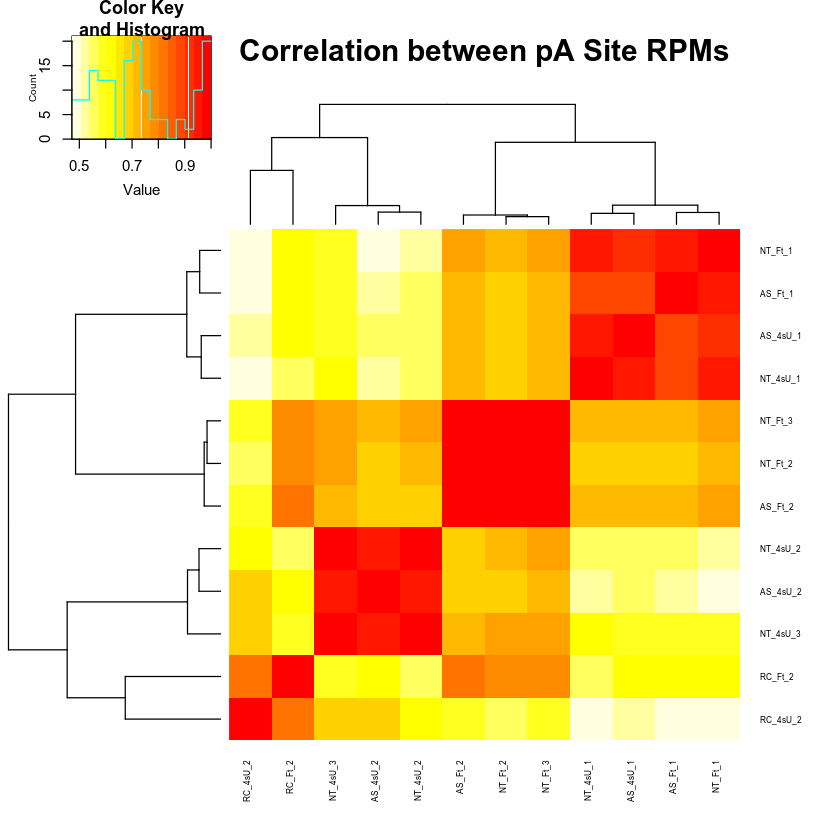

In [85]:
options(repr.plot.width=7, repr.plot.height=7)
df = pas[, grep("_rpm$", names(pas))]
names(df) = sub("_rpm", "", names(df))

# I prefer pheatmap, but it is not working now
heatmap.2(cor(df), col=rev(heat.colors(16)), main = "Correlation between pA Site RPMs", 
          trace="none", margins = c(5,5), cexRow = 0.5, cexCol = 0.5)

We can see that batch 1 samples (C_1 and N_1) are highligh correlated with each other but weakly correlated with batch 2 and batch 3 samples. Maybe it is a good idea to remove batch 1 samples from further analysis.

**This is the end of Part-2 of the pipeline. The *pas* data frame can be saved for further analysis.**

In [60]:
write.csv(pas, file.path(result_dir, "pas.csv"), row.names=F)

In [10]:
pas = read.csv(file.path(result_dir, "pas.csv"), as.is=T)

# Cells bellow are still under construction:

## Add RBP binding data (RNAcompete and eCLIP)

## Annotate repeat elements (such as IRAlu) in 3'UTRs

## 18. Calculate RPM ratios
* Prx: Proximal (previously used "proximal")
* Dis: Distal (previously used "distal")
* d2p_ratio: Distal to Proximal Ratio (log2) (previously used "d2p_ratio")
* RE: Relative Expression or RPM Ratio (previously used "rpm_ratio")
* pap: A data frame containing data related to poly(A) pairs

In [62]:
require(MASS)
require(grid)
require(ggplot2)
require(gridExtra)


#### Calculate isoform ratios between fractions 
if(length(fractions) > 1){
  for(batch in batches){
    for(treatment in treatments){
      for(i in 1:length(fractions[-1])){
        for(j in (i+1):length(fractions)){
          # only keep desirable comparisons
          if((exists("comparisons") && paste(fractions[j], fractions[i], sep="_") %in% comparisons) | 
             !exists("comparisons")){
            col1 = paste(treatment, fractions[i], batch, "rpm", sep="_")
            col2 = paste(treatment, fractions[j], batch, "rpm", sep="_")
            if(all(c(col1, col2) %in% names(pas))){
              if(!paste(treatment, fractions[j], fractions[i], batch, "RE", sep="_") %in% names(pas)){ 
                pas[, paste(treatment, fractions[j], fractions[i], batch, "RE", sep = "_")] = 
                  log2(pas[,col2]) - log2(pas[,col1])
              }
            }
          }
        }
      }
    }
  }
  if(length(batches) > 1){
    for(treatment in treatments){
      col_to_be_avaraged = grep(paste0(treatment, "_", fractions[j], "_", fractions[i], ".+_RE"), names(pas), value=T)
      col_name_avarage = paste0(treatment, "_", fractions[j], "_", fractions[i], "_mean_RE")
      if(length(col_to_be_avaraged) > 1){
        pas[, col_name_avarage] = rowMeans(pas[, col_to_be_avaraged])
      }
    }
  }
}

Loading required package: grid
Loading required package: gridExtra

Attaching package: ‘gridExtra’

The following object is masked from ‘package:Biobase’:

    combine

The following object is masked from ‘package:BiocGenerics’:

    combine

The following object is masked from ‘package:dplyr’:

    combine



In [63]:
#### Calculate isoform ratios between treatments 
if(length(treatments) > 1){
  for(batch in batches){
    for(fraction in fractions){
      for(i in 1:length(treatments[-1])){
        for(j in (i+1):length(treatments)){
          # only keep desirable comparisons
          if((exists("comparisons") && paste(treatments[j], treatments[i], sep="_") %in% comparisons) | 
             !exists("comparisons")){
            col1 = paste(treatments[i], fraction, batch, "rpm", sep="_")
            col2 = paste(treatments[j], fraction, batch, "rpm", sep="_")
            if(all(c(col1, col2) %in% names(pas))){
              if(!paste(treatments[j], treatments[i], fraction, batch, "RE", sep="_") %in% names(pas)){
                pas[, paste(treatments[j], treatments[i], fraction, batch, "RE", sep = "_")] = 
                  log2(pas[,col2]) - log2(pas[,col1])
              }
            }
          }
        }
      }
    }
  }
  if(length(batches) > 1){
    for(fraction in fractions){
      col_to_be_avaraged = grep(paste0(treatments[j], "_", treatments[i], "_", fraction,  ".+_RE"), names(pas), value=T)
      col_name_avarage = paste0(treatments[j], "_", treatments[i], "_", fraction, "_mean_RE")
      if(length(col_to_be_avaraged) > 1){
        pas[, col_name_avarage] = rowMeans(pas[, col_to_be_avaraged])
      }
    }
  }
}

In [64]:
#### Calculate delta abundance between fractions
if(length(fractions) > 1){
  for(i in 1:(length(fractions)-1)){
    for(j in (i+1):length(fractions)){
      # only keep desirable comparisons
      if((exists("comparisons") && paste(fractions[j], fractions[i], sep="_") %in% comparisons) | 
         !exists("comparisons")){
        for(treatment in treatments){
          for(batch in batches){
            col_name_1 =  paste(treatment, fractions[i], batch, "usage", sep="_")
            col_name_2 =  paste(treatment, fractions[j], batch, "usage", sep="_")
            if(all(c(col_name_1, col_name_2) %in% names(pas))){
              pas[, paste("Delta_abn", treatment, fractions[j], "vs", fractions[i], batch, sep="_")] = pas[, col_name_2]-pas[,col_name_1]
            }
          }
          if(length(batches) > 1){
            col_name_avarage = paste("Delta_abn", treatment, fractions[j], "vs", fractions[i], sep="_")
            if(length(grep(col_name_avarage, names(pas))) > 1){
              pas[, col_name_avarage] = rowMeans(pas[, grep(col_name_avarage, names(pas))])
            }
          }
        }
      }
    }
  }
}

In [65]:
#### Calculate delta abundance between treatments
if(length(treatments) > 1){
  for(i in 1:(length(treatments)-1)){
    for (j in (i+1):length(treatments)){
      # only keep desirable comparisons
      if((exists("comparisons") && paste(treatments[j], treatments[i], sep="_") %in% comparisons) | 
         !exists("comparisons")){
        for (fraction in fractions){
          for (batch in batches){
            col_name_1 =  paste(treatments[i], fraction, batch, "usage", sep="_")
            col_name_2 =  paste(treatments[j], fraction, batch, "usage", sep="_")
            if(all(c(col_name_1, col_name_2) %in% names(pas))){
              pas[, paste("Delta_abn", treatments[j], "vs", treatments[i], fraction, batch, sep="_")] = pas[, col_name_2]-pas[,col_name_1]
            }
          }
          if (length(batches) > 1){
            col_name_avarage = paste("Delta_abn", treatments[j], "vs", treatments[i], fraction, sep="_")
            if(length(grep(col_name_avarage, names(pas))) > 1){
              pas[, col_name_avarage] = rowMeans(pas[, grep(col_name_avarage, names(pas))])
            }
          }
        }
      }
    }
  }
}

In [66]:
#### Calculate APA p_values using fisher's exact test accross fractions
if(length(fractions) > 1){
  for(i in 1:(length(fractions)-1)){
    for (j in (i+1):length(fractions)){
      # only keep desirable comparisons
      if((exists("comparisons") && paste(fractions[j], fractions[i], sep="_") %in% comparisons) | 
         !exists("comparisons")){
        for(treatment in treatments){
          for (batch in batches){
            col_name_1 =  paste(treatment, fractions[i], batch, "count", sep="_")
            col_name_2 =  paste(treatment, fractions[j], batch, "count", sep="_")
            if(all(c(col_name_1, col_name_2) %in% names(pas))){
              col_name_1_gene = sub("count", "gene", col_name_1)
              col_name_2_gene = sub("count", "gene", col_name_2)
              # only keep useful columns
              dat = pas[,c("gene_symbol", col_name_1, col_name_2, col_name_1_gene, col_name_2_gene)]
              # calculate p values (adjusted within gene)
              p.vals = APA.fisher(dat)
              p.val.signs = sign(pas[, paste("Delta_abn", treatment, fractions[j], "vs", fractions[i], batch, sep="_")])
              pas[, paste("APA_SS", treatment, fractions[j], "vs", fractions[i], batch, sep="_")] = -1*p.val.signs * log10(p.vals)
            }
          }
        }
      }
    }
  }
}

In [67]:
#### Calculate APA p_values using fisher's exact test accross treatments:
if(length(treatments) > 1){
  for(i in 1:(length(treatments)-1)){
    for(j in (i+1):length(treatments)){
      # only keep desirable comparisons
      if((exists("comparisons") && paste(treatments[j], treatments[i], sep="_") %in% comparisons) | 
         !exists("comparisons")){
        for(fraction in fractions){
          for(batch in batches){
            col_name_1 =  paste(treatments[i], fraction, batch, "count", sep="_")
            col_name_2 =  paste(treatments[j], fraction, batch, "count", sep="_")
            if(all(c(col_name_1, col_name_2) %in% names(pas))){
              col_name_1_gene = sub("count", "gene", col_name_1)
              col_name_2_gene = sub("count", "gene", col_name_2)
              # only keep useful columns
              dat = pas[,c("gene_symbol", col_name_1, col_name_2, col_name_1_gene, col_name_2_gene)]
              # calculate p values (adjusted within gene)
              p.vals = APA.fisher(dat)
              p.val.signs = sign(pas[, paste("Delta_abn", treatments[j], "vs", treatments[i], fraction, batch, sep="_")])
              pas[, paste("APA_SS", treatments[j], "vs", treatments[i], fraction, batch, sep="_")] = -1*p.val.signs * log10(p.vals)
            }
          }
        }
      }
    }
  }
}

In [68]:
#### Calculate genewise foldchange using the RPM accross fractions:
if(length(fractions) > 1){
  for(i in 1:(length(fractions)-1)){
    for(j in (i+1):length(fractions)){
      # only keep desirable comparisons
      if((exists("comparisons") && paste(fractions[j], fractions[i], sep="_") %in% comparisons) | 
         !exists("comparisons")){
        for(treatment in treatments){
          for(batch in batches){
            col_name_1 =  paste("Gene_RPM", treatment, fractions[i], batch, sep="_")
            col_name_2 =  paste("Gene_RPM", treatment, fractions[j], batch, sep="_")
            if(all(c(col_name_1, col_name_2) %in% names(pas))){
              pas[, paste("Gene_FC", treatment, fractions[j], "vs", fractions[i], batch, sep="_")] = log2(pas[, col_name_2])-log2(pas[,col_name_1]) 
            }
          }
          if(length(batches) > 1){
            col_name_avarage = paste("Gene_FC", treatment, fractions[j], "vs", fractions[i], sep="_")
            if(length(grep(col_name_avarage, names(pas)))>1){
              pas[, col_name_avarage] = rowMeans(pas[, grep(col_name_avarage, names(pas))])
            }
          }
        }
      }
    }
  }
}

In [69]:
#### Calculate genewise foldchange using the RPM accross treatments:
if(length(treatments) > 1){
  for(i in 1:(length(treatments)-1)){
    for(j in (i+1):length(treatments)){
      # only keep desirable comparisons
      if((exists("comparisons") && paste(treatments[j], treatments[i], sep="_") %in% comparisons) | 
         !exists("comparisons")){
        for(fraction in fractions){
          for(batch in batches){
            col_name_1 =  paste("Gene_RPM", treatments[i], fraction, batch, sep="_")
            col_name_2 =  paste("Gene_RPM", treatments[j], fraction, batch, sep="_")
            if(all(c(col_name_1, col_name_2) %in% names(pas))){
              pas[, paste("Gene_FC", treatments[j], "vs", treatments[i], fraction, batch, sep="_")] = log2(pas[, col_name_2])-log2(pas[,col_name_1])
            }
          }
          if (length(batches) > 1){
            col_name_avarage = paste("Gene_FC", treatments[j], "vs", treatments[i], fraction, sep="_")
            if(length(grep(col_name_avarage, names(pas)))>1){
              pas[, col_name_avarage] = rowMeans(pas[, grep(col_name_avarage, names(pas))])
            }
          }
        }
      }
    }
  }
}

In [70]:
#### 3'UTR RPM accross treatments:
if(length(treatments) > 1){
  for(i in 1:(length(treatments)-1)){
    for (j in (i+1):length(treatments)){
      # only keep desirable comparisons
      if((exists("comparisons") && paste(treatments[j], treatments[i], sep="_") %in% comparisons) | 
         !exists("comparisons")){
        for(fraction in fractions){
          for (batch in batches){
            col_name_1 =  paste("UTR_RPM", treatments[i], fraction, batch, sep="_")
            col_name_2 =  paste("UTR_RPM", treatments[j], fraction, batch, sep="_")
            if(all(c(col_name_1, col_name_2) %in% names(pas))){
              pas[, paste("UTR_FC", treatments[j], "vs", treatments[i], fraction, batch, sep="_")] = log2(pas[, col_name_2])-log2(pas[,col_name_1])
            }
          }
          if(length(batches) > 1){
            col_name_avarage = paste("UTR_FC", treatments[j], "vs", treatments[i], fraction, sep="_")
            if(length(grep(col_name_avarage, names(pas)))>1){
              pas[, col_name_avarage] = rowMeans(pas[, grep(col_name_avarage, names(pas))])
            }
          }
        }
      }
    }
  }
}

In [71]:
withCallingHandlers(suppressWarnings(warning("hi")), warning = function(w) {
    print(w)
})

suppressWarnings

function (expr) 
{
    ops <- options(warn = -1)
    on.exit(options(ops))
    withCallingHandlers(expr, warning = function(w) invokeRestart("muffleWarning"))
}
<bytecode: 0x55a969f7a458>
<environment: namespace:base>

In [72]:
#### Calculate p values for genewise foldchange using chi-squared test (too slow with fisher's exact)
gene.df = unique(pas[,c("gene_symbol", grep("_gene", names(pas), value = T))])
#### Accross fractions:
if(length(fractions) > 1){
  for(i in 1:(length(fractions)-1)){
    for (j in (i+1):length(fractions)){
      # only keep desirable comparisons
      if((exists("comparisons") && paste(fractions[j], fractions[i], sep="_") %in% comparisons) | 
         !exists("comparisons")){
        for(treatment in treatments){
          for (batch in batches){
            col_name_1 =  paste(treatment, fractions[i], batch, "gene", sep="_")
            col_name_2 =  paste(treatment, fractions[j], batch, "gene", sep="_")
            
            if(all(c(col_name_1, col_name_2) %in% names(pas))){
              # prepare input
              dat = cbind(gene.df[,c(col_name_1, col_name_2)], 
                          col_name_1_sum = sum(gene.df[,col_name_1], na.rm = T),
                          col_name_2_sum = sum(gene.df[,col_name_2], na.rm = T))
              
              # calculate p values (adjusted)
              gene.df$p.vals = suppressWarnings(genewise.chi(dat))
              pas = merge(pas, gene.df[,c("gene_symbol", "p.vals")], by = "gene_symbol", sort=F)
              
              p.val.signs = sign(pas[, paste("Gene_FC", treatment, fractions[j], "vs", fractions[i], batch, sep="_")])
              pas$p.vals = -1*p.val.signs * log10(pas$p.vals)
              names(pas) = sub("^p\\.vals$", paste("Gene_SS", treatment, fractions[j], "vs", fractions[i], batch, sep="_"), names(pas))
            }
          }
        }
      }
    }
  }
}
rm(dat)

In [73]:
#### Accross treatments:
if(length(treatments) > 1){
  for(i in 1:(length(treatments)-1)){
    for(j in (i+1):length(treatments)){
      # only keep desirable comparisons
      if((exists("comparisons") && paste(treatments[j], treatments[i], sep="_") %in% comparisons) | 
         !exists("comparisons")){
        for(fraction in fractions){
          for(batch in batches){
            col_name_1 =  paste(treatments[i], fraction, batch, "gene", sep="_")
            col_name_2 =  paste(treatments[j], fraction, batch, "gene", sep="_")
            
            if(all(c(col_name_1, col_name_2) %in% names(pas))){
              # prepare input
              dat = cbind(gene.df[,c(col_name_1, col_name_2)], 
                          col_name_1_sum = sum(gene.df[,col_name_1], na.rm = T),
                          col_name_2_sum = sum(gene.df[,col_name_2], na.rm = T))
              
              # calculate p values (adjusted)
              gene.df$p.vals = suppressWarnings(genewise.chi(dat))
              pas = merge(pas, gene.df[,c("gene_symbol", "p.vals")], by = "gene_symbol", sort=F)
              
              p.val.signs = sign(pas[, paste("Gene_FC", treatments[j], "vs", treatments[i], fraction, batch, sep="_")])
              pas$p.vals = -1*p.val.signs * log10(pas$p.vals)
              names(pas) = sub("^p\\.vals$", paste("Gene_SS", treatments[j], "vs", treatments[i], fraction, batch, sep="_"), names(pas))
            }
          }
        }
      }
    }
  }
}
rm(dat)
rm(gene.df)

Warning message in rm(dat):
“object 'dat' not found”

In [74]:
#### Replace the NaN values in the APA_SS columns with 0
pas[, grep("_SS", names(pas))][is.na(pas[, grep("_SS", names(pas))])] = 0

#### Change the column names containing "usage"
names(pas) = sub("(.+)_usage", "Isoform_abn_\\1", names(pas))

In [75]:
write.csv(pas, file.path(result_dir, "pas.csv"), row.names=F)

In [76]:
#### Calculate REDs
pA3utr = subset(pas, CDS_size > 0 & region == "3UTR" & !is.na(exonic_3UTR_seq)) 
# Add pseudocounts
if(!exists("USE_PSEUDOCOUNTS") || USE_PSEUDOCOUNTS == T){
  pA3utr[,grep("_count$", names(pA3utr))] = pA3utr[, grep("_count$", names(pA3utr))] + 1
}
colname_pattern = "exonic_3UTR_seq|UTR3_size|UTR3_GC|_counts$|_sites$"
if(exists("additional_RED_pattern")){
  colname_pattern = paste0(colname_pattern, "|", additional_RED_pattern)
}
pap = get_red(data = pA3utr, cols = grep(colname_pattern, names(pA3utr), value=T), 
              neighbor = neighbor, toptwo = toptwo, match_only=F)

# Default aUTR size
pap$pA_pos_Prx = as.integer(sub(".+[+-]", "", pap$Prx_pA))
pap$pA_pos_Dis = as.integer(sub(".+[+-]", "", pap$Dis_pA))
mean(pap$pA_pos_Prx - pap$pA_pos_Dis == 0)
mean(pap$Prx_pA == pap$Dis_pA, na.rm = T)

pap$aUTR_size = abs(pap$pA_pos_Dis - pap$pA_pos_Prx) 

# More accurate aUTR size
index = which(pap$UTR3_size_Dis > 0 & pap$UTR3_size_Prx > 0)
pap[index,]$aUTR_size = pap[index,]$UTR3_size_Dis - pap[index,]$UTR3_size_Prx
pap = pap[pap$aUTR_size > 10, ]



pap = merge(pap, unique(pas[, c("gene_symbol", "CDS_size")]), all.x=T, sort=F)

Num_pA = as.data.frame(table(pA3utr$gene_symbol))
names(Num_pA) = c("gene_symbol", "Num_pA")
pap = merge(pap, Num_pA, by = "gene_symbol", all.x = T, sort=F)
rm(Num_pA)


# Add aUTR GC
require(Biostrings)
aUTR_seq = apply(pap, 1, 
                 function(row) substr(row["exonic_3UTR_seq_Dis"], 
                                      start = as.integer(row["UTR3_size_Prx"])+1, 
                                      stop = row["UTR3_size_Dis"]))
aUTR_seq = DNAStringSet(aUTR_seq)
base_fraction = alphabetFrequency(aUTR_seq, baseOnly=T, as.prob=T)
pap$aUTR_GC = base_fraction[, "C"] + base_fraction[, "G"]


[1] 0.9229937

[1] 0.9229937

In [77]:
pAid2pos = function(pap){
  pAid.i = pap$Prx_pA
  pAid.j = pap$Dis_pA
  
  pA.pos.df = as.data.frame(do.call(rbind, strsplit(pAid.i, "[+-]")), 
                            stringsAsFactors = F)
  #pos.i.string = "Prx_pA_pos"
  names(pA.pos.df) = c("chr", "Prx_pA_pos")
  pA.pos.df$chr = as.character(pA.pos.df$chr)
  pA.pos.df$Prx_pA_pos = as.integer(pA.pos.df$Prx_pA_pos)
  pA.pos.df$strand = as.vector(sub(".*?([+-])\\d*", "\\1", pAid.i, perl = T))
  
  pA.pos.df$Dis_pA_pos = as.data.frame(do.call(rbind, strsplit(pAid.j, "[+-]")), 
                                          stringsAsFactors = F)[,2]
  pA.pos.df$Dis_pA_pos = as.integer(pA.pos.df$Dis_pA_pos)
  
  cbind(pA.pos.df, pap)
}



In [78]:
x = pAid2pos(pap)

Plot distribution aUTR sizes:

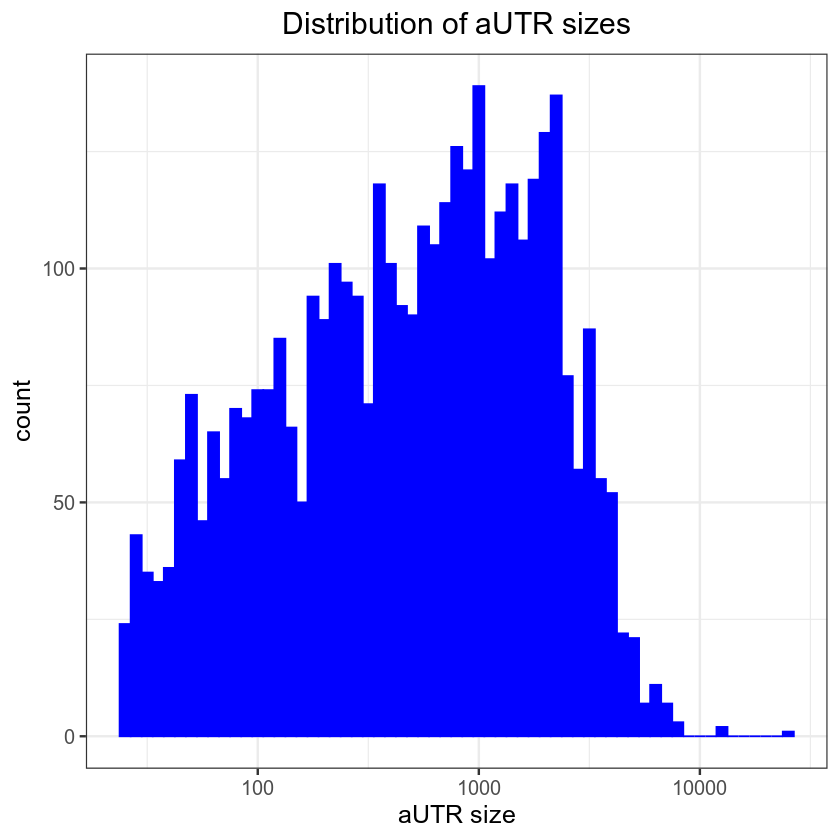

In [79]:
ggplot(data = pap, aes(x = pap$aUTR_size)) + 
  geom_histogram(fill="blue", colour="blue", binwidth = 0.05) +
  scale_x_log10() +
  xlab("aUTR size") +
  ggtitle("Distribution of aUTR sizes")

Compare cUTR and aUTR GC content:

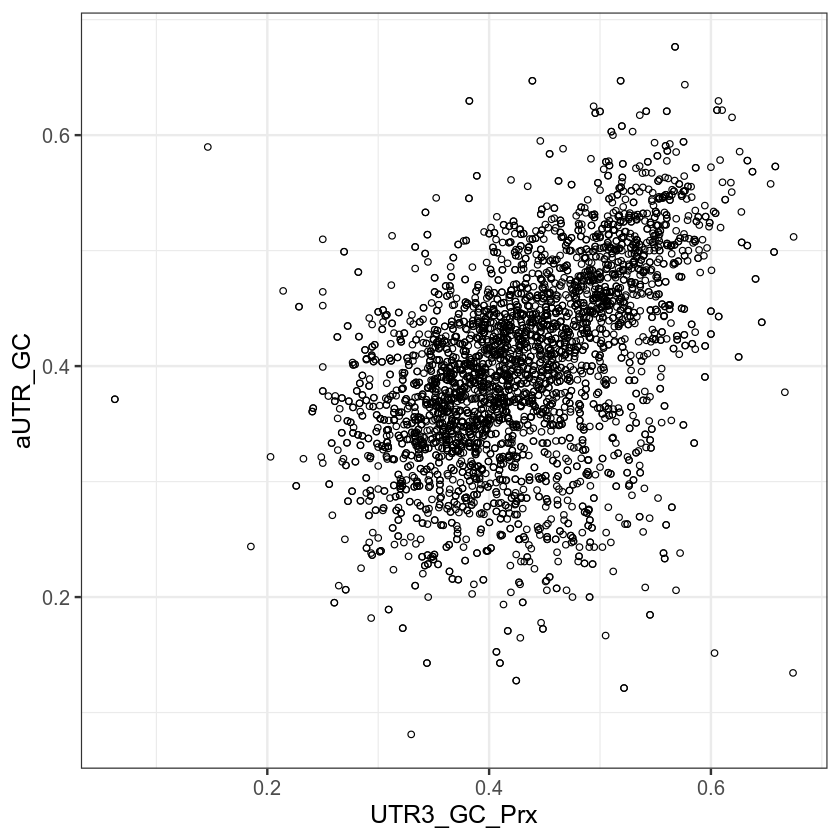

In [80]:
ggplot(pap, aes(x=UTR3_GC_Prx, y=aUTR_GC)) +
  geom_point(shape=1)

Compare cUTR and aUTR sizes

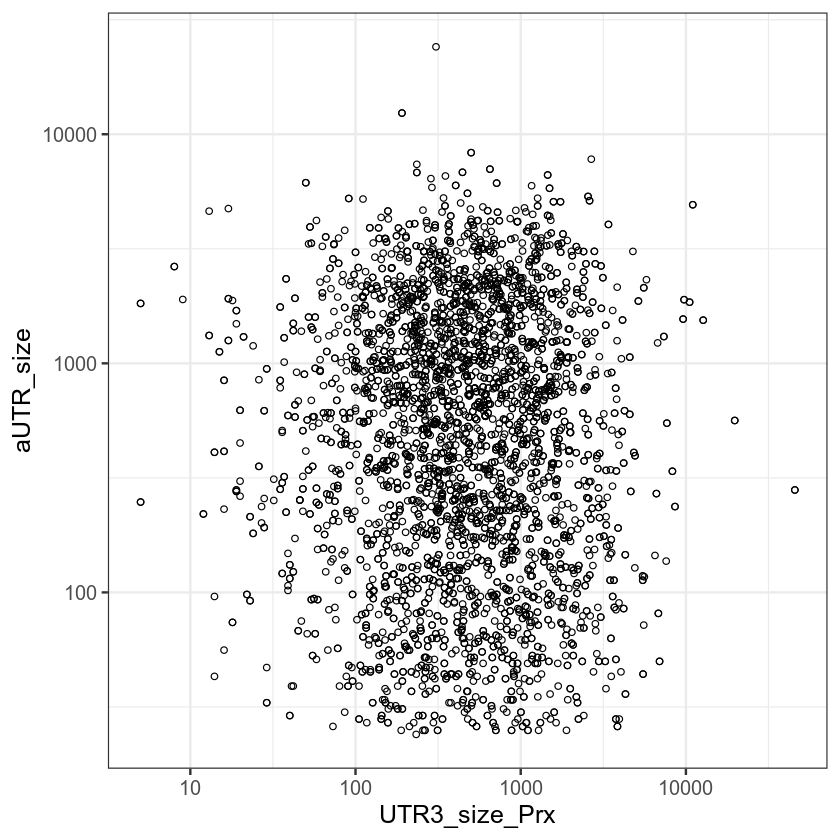

In [81]:
ggplot(pap, aes(x=UTR3_size_Prx, y=aUTR_size)) +
  geom_point(shape=1) +
  scale_x_log10() +
  scale_y_log10()

In [82]:
#### calculate and plot RED accross fractions:
if(length(fractions) > 1){
  p.list = list()
  k = 1
  for(i in 1:(length(fractions)-1)){
    for(j in (i+1):length(fractions)){
      # only keep desirable comparisons
      if((exists("comparisons") && paste(fractions[j], fractions[i], sep="_") %in% comparisons) | 
         !exists("comparisons")){
        for(treatment in treatments){
          for(batch in batches){
            col_name_1 =  paste(treatment, fractions[i], batch, "d2p_ratio", sep="_")
            col_name_2 =  paste(treatment, fractions[j], batch, "d2p_ratio", sep="_")
            if(all(c(col_name_1, col_name_2) %in% names(pap))){
              pap[, paste(treatment, fractions[j], "vs", fractions[i], batch, "RED", sep="_")] = pap[, col_name_2]-pap[,col_name_1] 
            }
          }
          if(length(batches) > 1){
            col_to_be_avaraged = grep(paste0(treatment, "_", fractions[j], "_vs_", fractions[i], ".+_RED"), names(pap), value=T)
            col_name_avarage = paste0(treatment, "_", fractions[j], "_vs_", fractions[i], "_mean_RED")
            if(length(col_to_be_avaraged) > 1){
              pap[, col_name_avarage] = rowMeans(pap[, col_to_be_avaraged])
            }
          }
        }
      }
    }
  }
}

In [83]:
#### Calculate APA accross treatments:
if(length(treatments) > 1){
  for(i in 1:(length(treatments)-1)){
    for(j in (i+1):length(treatments)){
      # only keep desirable comparisons
      if((exists("comparisons") && paste(treatments[j], treatments[i], sep="_") %in% comparisons) | 
         !exists("comparisons")){
        for(fraction in fractions){
          for(batch in batches){
            col_name_1 =  paste(treatments[i], fraction, batch, "d2p_ratio", sep="_")
            col_name_2 =  paste(treatments[j], fraction, batch, "d2p_ratio", sep="_")
            if(all(c(col_name_1, col_name_2) %in% names(pap))){
              pap[, paste(treatments[j], "vs", treatments[i], fraction, batch, "RED", sep="_")] = pap[, col_name_2]-pap[,col_name_1]
            }
          }
          if(length(batches) > 1){
            col_to_be_avaraged = grep(paste0(treatments[j], "_vs_", treatments[i], "_", fraction,  ".+_RED"), names(pap), value=T)
            col_name_avarage = paste0(treatments[j], "_vs_", treatments[i], "_", fraction, "_mean_RED")
            if(length(col_to_be_avaraged) > 1){
              pap[, col_name_avarage] = rowMeans(pap[, col_to_be_avaraged])
            }
          }
        }
      }
    }
  }
}

In [84]:
keep = c("gene_symbol", "uORF", "UTR5_size", "UTR5_GC", "CDS_size", "CDS_GC", "max_intron_size", 
         "min_intron_size", "total_intron_size", "num_intron", "description")
pap = merge(pap, unique(pA3utr[, keep]), all.x = T, sort=F)
pap = pap[, -c(grep("^chr$|pA_pos$|strand", names(pap)))]

if(exists("additional_RED_pattern")){
  pap = pap[, c("gene_symbol","gene_id", "Prx_pA", "Dis_pA", "UTR3_size_Prx", "UTR3_size_Dis", "aUTR_size", 
                        grep(paste0(c(sub("\\$$", "", additional_RED_pattern), "^exonic_", "_RED$", "_count_"), collapse = "|"), names(pap), value=T), 
                        keep)]
}else{
  pap = pap[, c("gene_symbol","gene_id", "Prx_pA", "Dis_pA", "UTR3_size_Prx", "UTR3_size_Dis", "aUTR_size", 
                        grep(paste0(c("^exonic_", "_RED$", "_count_"), collapse = "|"), names(pap), value=T), 
                        keep)]
}



write.csv(pap, file.path(result_dir, "pap.csv"), row.names = F)

rm(pA3utr)

ERROR: Error in `[.data.frame`(pap, , c("gene_symbol", "gene_id", "Prx_pA", "Dis_pA", : undefined columns selected


In [ ]:
names(pap)